<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v13: Extending all callbacks for value stats, magnitude stats, and activity stats, plus a new HistoryStats callback
I've since realised that:
a) I need to collect magnitude stats in order to produce sensible model-wide plots, and
b) I need to collect activity stats across all data types (layer outputs, layer backprop gradients, variables, variable gradients)

So here I've proving out changes to improve code re-use and standardise how that's all collected. Hopefully also to do it in a somewhat more efficient way.

Timing:
* 36ms/epoch - baseline
* 220ms/epoch - single callback, value stats only (high variance)
* 140ms/epoch - single callback, activity stats only
* 280ms/epoch - single callback, value + activity stats

In [30]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/ml-learning.git repo

# lock to revision
#!cd repo && git checkout 704ef35
!cd repo && git pull

import sys
sys.path.append('repo')

import train_observability_toolkit as tot
from importlib import reload
reload(tot)

HEAD is now at 68b3aaa Moved the value, magnitude, and activity stats properties into the mixins
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (3/3), 1.12 KiB | 163.00 KiB/s, done.
From https://github.com/malcolmlett/ml-learning
   68b3aaa..816210b  main       -> origin/main
Updating 68b3aaa..816210b
Fast-forward
 train_observability_toolkit.py | 190 ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 188 insertions(+), 2 deletions(-)


<module 'train_observability_toolkit' from '/content/repo/train_observability_toolkit.py'>

In [4]:
import train_observability_toolkit_test
reload(train_observability_toolkit_test)
reload(tot)
train_observability_toolkit_test.run_test_suite()

All train_observability_toolkit tests passed.


In [5]:
import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models, datasets, optimizers, metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit
import tqdm

## Basic setup


train_X: (300, 2), train_Y: (300, 1), test_X: (100, 2), test_Y: (100, 1)


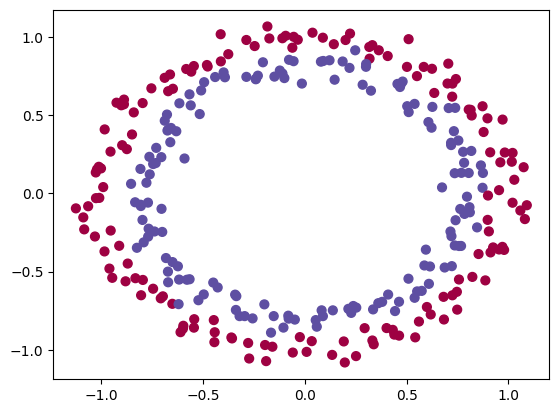

In [6]:
def plot_fit(history = None):
  pnum = 1

  plt.figure(layout='constrained')
  if history != None:
    plt.subplot(1,pnum,1)
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
  plt.show()

def binary_classification_model(init_scheme):
  """
  init_scheme: one of "zeros", "large_normal", "he_normal"
  """
  if init_scheme == "zeros":
    kernel_initializer='zeros'
  elif init_scheme == "large_normal":
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=10.)
  elif init_scheme == "he_normal":
    kernel_initializer='he_normal'
  else:
    raise ValueError("Unknown init_scheme")

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)
  ])

  return model

def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  test_X = test_X
  test_Y = test_Y.reshape((-1, 1))
  return train_X, train_Y, test_X, test_Y

train_X, train_Y, test_X, test_Y = binary_classification_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}, test_X: {test_X.shape}, test_Y: {test_Y.shape}")

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

## History Stats

**TODO**

* Something is quite wrong with my custom fit() function, producing very different loss curves. Need to investigate.

In [58]:
reload(tot)
tf.config.run_functions_eagerly(False)

model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse', 'binary_crossentropy'])
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history = tot.fit(model, dataset.batch(32), epochs=10, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), tot.HistoryStats(per_step=True)])
#history = model.fit(dataset.batch(32), epochs=10, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), tot.HistoryStats(per_step=True)])

Training via custom fit() function. Will produce a few warnings; you can usually ignore these.


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_187']
Received: inputs=Tensor(shape=(32, 2))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_187']
Received: inputs=Tensor(shape=(12, 2))
  warnings.warn(msg)


Epoch     1 - 3.31s/epoch: accuracy: 0.5100  binary_crossentropy: 0.6959  loss: 0.7104  mse: 0.2514  
Epoch     2 - 59.71ms/epoch: accuracy: 0.5000  binary_crossentropy: 0.6874  loss: 0.6948  mse: 0.2472  
Epoch     3 - 62.33ms/epoch: accuracy: 0.5000  binary_crossentropy: 0.6859  loss: 0.6810  mse: 0.2464  
Epoch     4 - 69.70ms/epoch: accuracy: 0.5000  binary_crossentropy: 0.6842  loss: 0.6723  mse: 0.2456  
Epoch     5 - 62.06ms/epoch: accuracy: 0.5000  binary_crossentropy: 0.6825  loss: 0.6674  mse: 0.2448  
Epoch     6 - 64.75ms/epoch: accuracy: 0.5000  binary_crossentropy: 0.6807  loss: 0.6596  mse: 0.2438  
Epoch     7 - 64.66ms/epoch: accuracy: 0.5000  binary_crossentropy: 0.6780  loss: 0.6513  mse: 0.2425  
Epoch     8 - 64.98ms/epoch: accuracy: 0.5067  binary_crossentropy: 0.6748  loss: 0.6446  mse: 0.2410  
Epoch     9 - 67.86ms/epoch: accuracy: 0.5167  binary_crossentropy: 0.6707  loss: 0.6375  mse: 0.2389  
Epoch    10 - 60.54ms/epoch: accuracy: 0.5267  binary_crossentropy

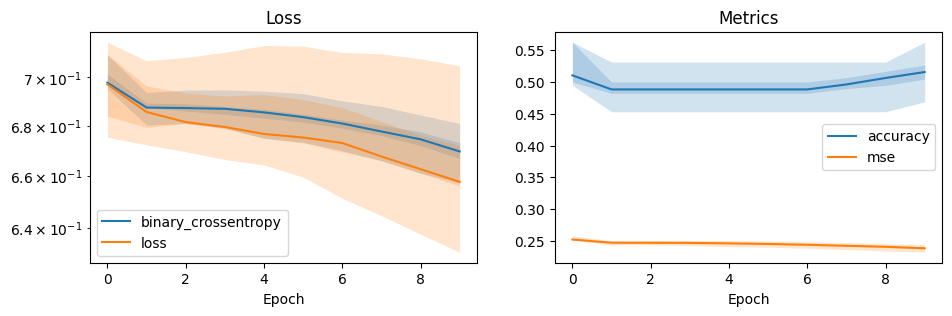

In [59]:
tot.plot_train_history(history)

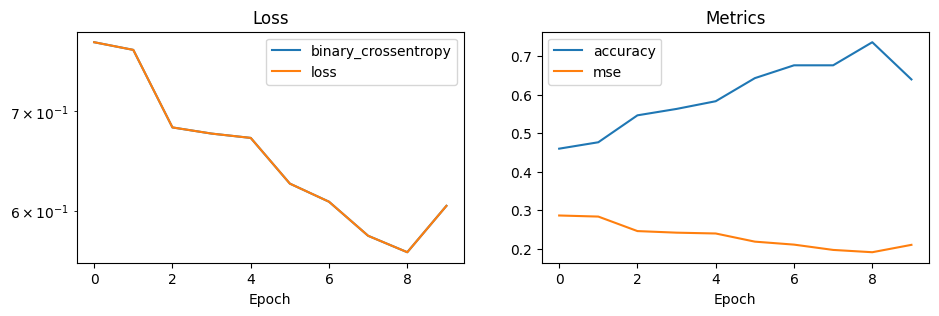

In [50]:
tot.plot_train_history(history, show_loss_percentiles=False, show_metric_percentiles=False)

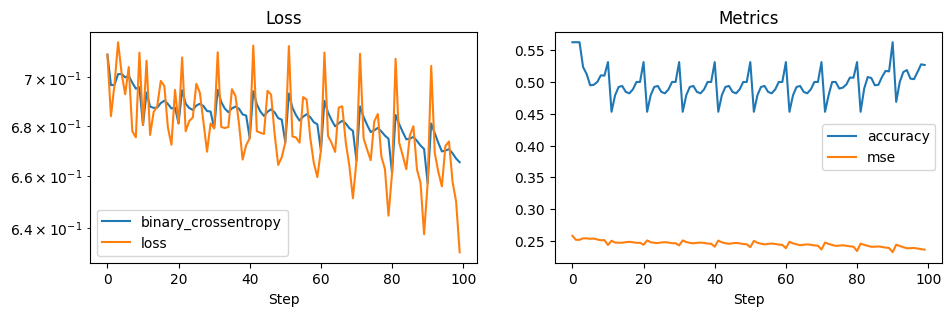

In [60]:
tot.plot_train_history(history, per_step=True)

## Data Collection

In [60]:
reload(tot)
tf.config.run_functions_eagerly(False)

variables = tot.VariableHistoryCallback(per_step=True, value_stats=True, activity_stats=True)
gradients = tot.GradientHistoryCallback(per_step=True)
outputs = tot.LayerOutputHistoryCallback(per_step=True, activity_stats=True)
output_gradients = tot.LayerOutputGradientHistoryCallback(per_step=True, activity_stats=True)

model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse', 'binary_crossentropy'])
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history = tot.fit(model, dataset.batch(32), epochs=10, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), variables, gradients, outputs, output_gradients, tot.HistoryStats(per_step=True)])

Training via custom fit() function. Will produce a few warnings; you can usually ignore these.


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_99']
Received: inputs=Tensor(shape=(32, 2))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_99']
Received: inputs=Tensor(shape=(12, 2))
  warnings.warn(msg)


Epoch     1 - 14.36s/epoch: accuracy: 0.4667  binary_crossentropy: 0.7100  loss: 0.7278  mse: 0.2582  
Epoch     2 - 529.42ms/epoch: accuracy: 0.5200  binary_crossentropy: 0.6884  loss: 0.6999  mse: 0.2477  
Epoch     3 - 544.23ms/epoch: accuracy: 0.5200  binary_crossentropy: 0.6852  loss: 0.6989  mse: 0.2461  
Epoch     4 - 527.65ms/epoch: accuracy: 0.5100  binary_crossentropy: 0.6804  loss: 0.6793  mse: 0.2437  
Epoch     5 - 652.54ms/epoch: accuracy: 0.5233  binary_crossentropy: 0.6773  loss: 0.6664  mse: 0.2422  
Epoch     6 - 555.83ms/epoch: accuracy: 0.5333  binary_crossentropy: 0.6736  loss: 0.6610  mse: 0.2404  
Epoch     7 - 536.72ms/epoch: accuracy: 0.5567  binary_crossentropy: 0.6695  loss: 0.6598  mse: 0.2384  
Epoch     8 - 559.85ms/epoch: accuracy: 0.5600  binary_crossentropy: 0.6632  loss: 0.6475  mse: 0.2353  
Epoch     9 - 649.59ms/epoch: accuracy: 0.5567  binary_crossentropy: 0.6572  loss: 0.6389  mse: 0.2325  
Epoch    10 - 564.16ms/epoch: accuracy: 0.5933  binary_cr

## Uber Plot

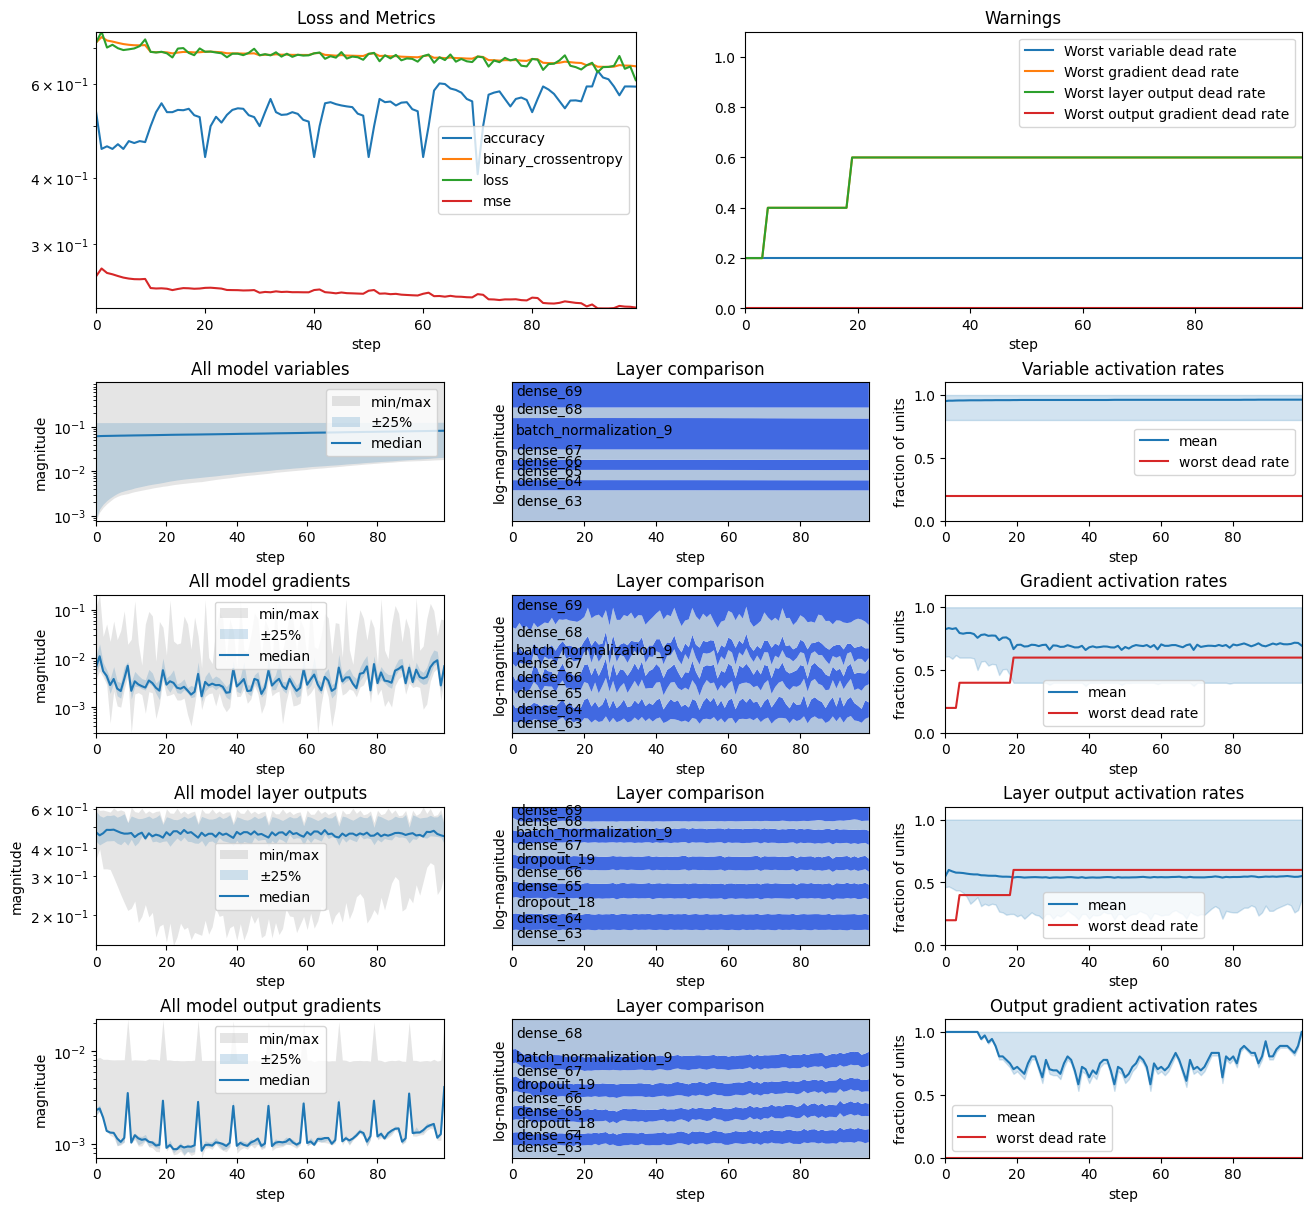

In [71]:
reload(tot)
tot.plot_history_overview([history, variables, gradients, outputs, output_gradients])

## History Plots

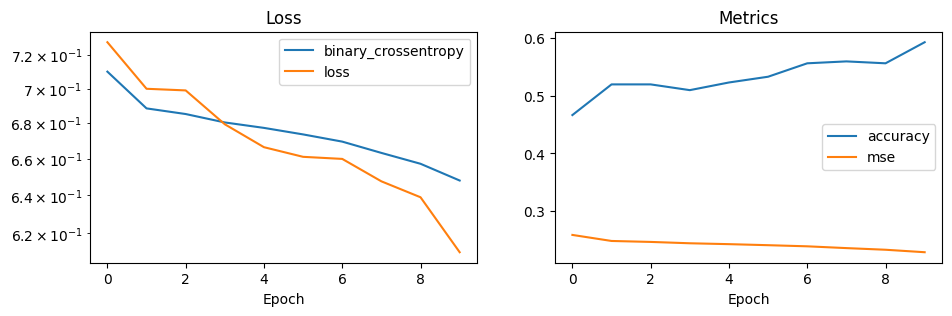

In [75]:
tot.plot_train_history(history, show_loss_percentiles=False, show_metric_percentiles=False)

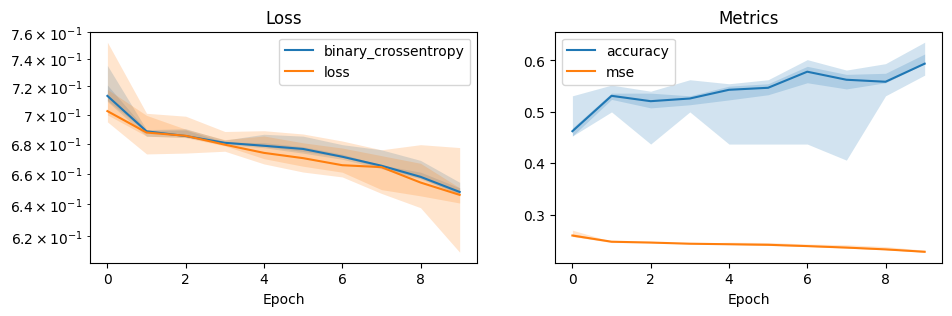

In [72]:
tot.plot_train_history(history)

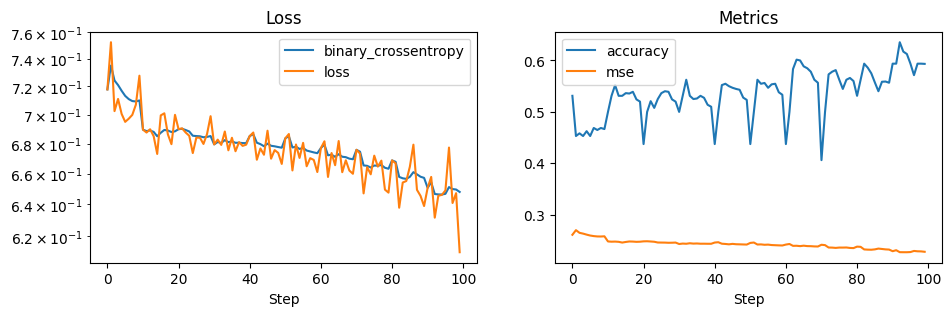

In [74]:
tot.plot_train_history(history, per_step=True)

## Individual Callback Plots


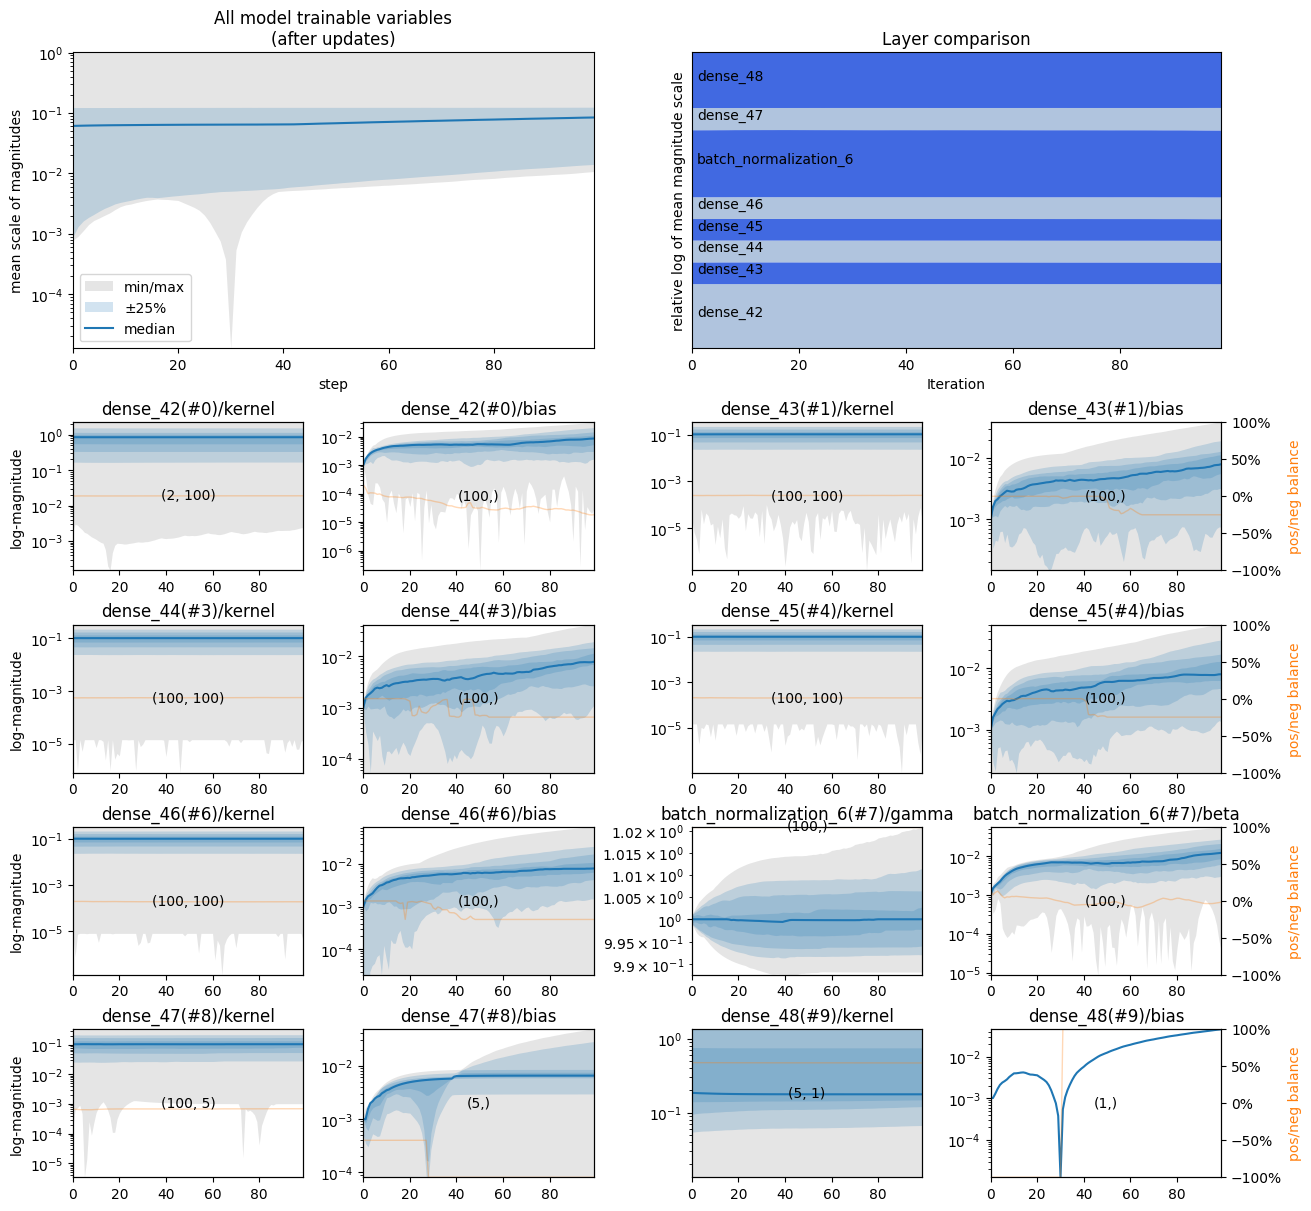

In [32]:
tot.plot_value_history(variables)

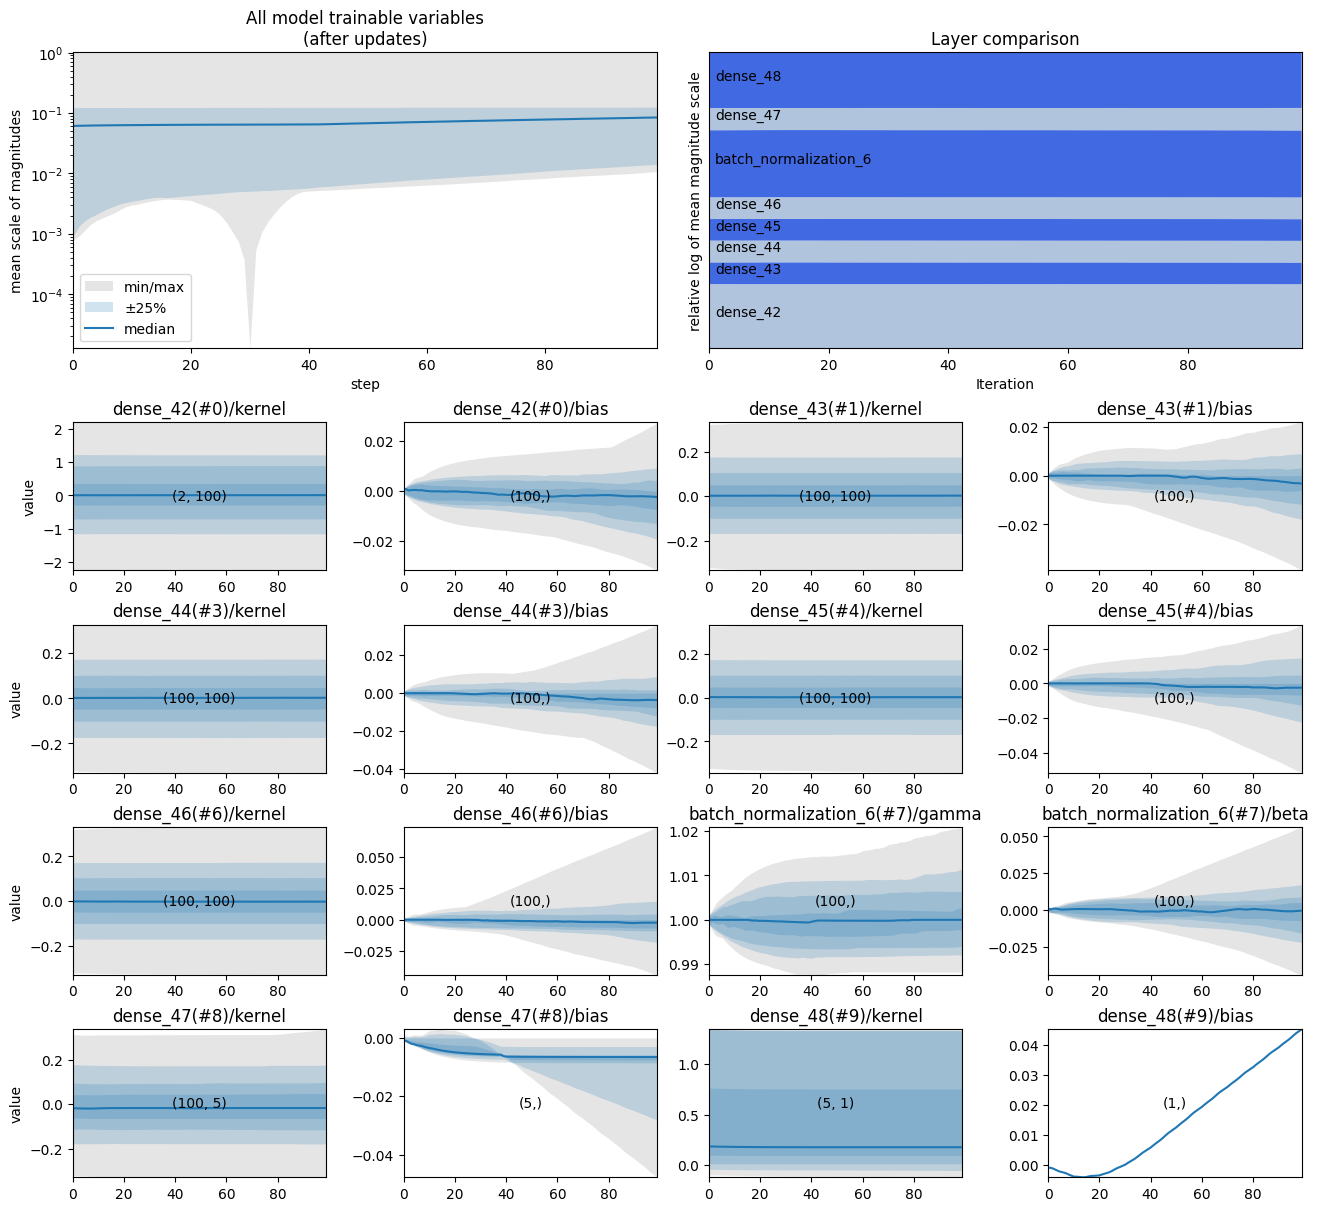

In [44]:
tot.plot_value_history(variables, magnitudes=False)

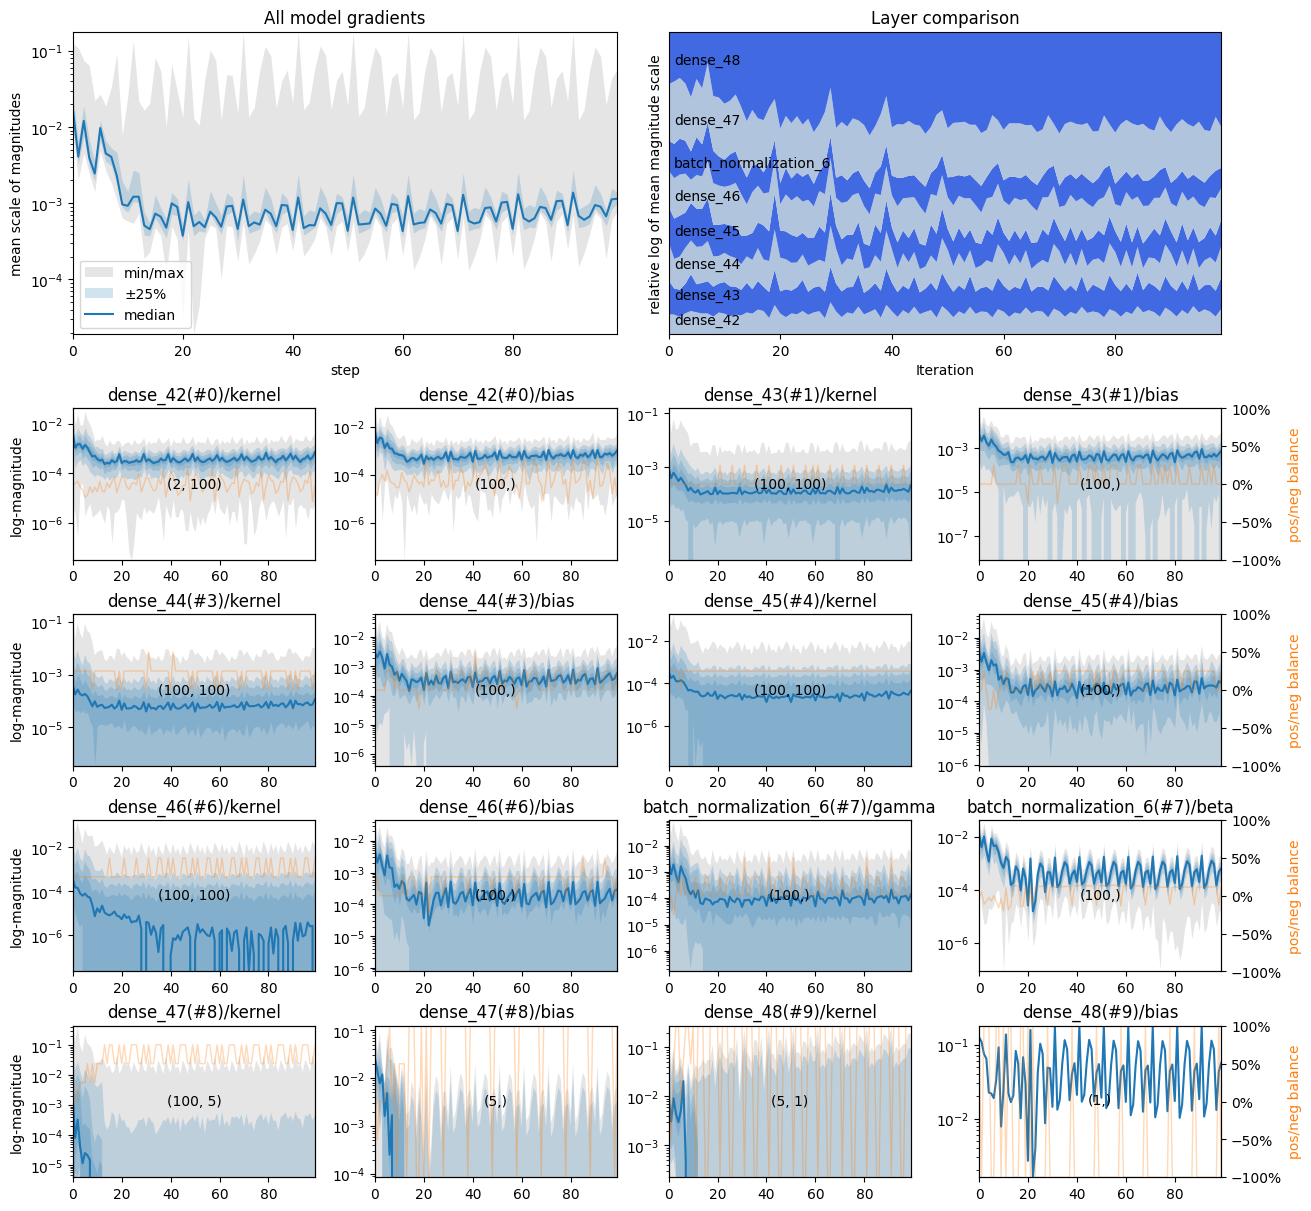

In [34]:
tot.plot_value_history(gradients)

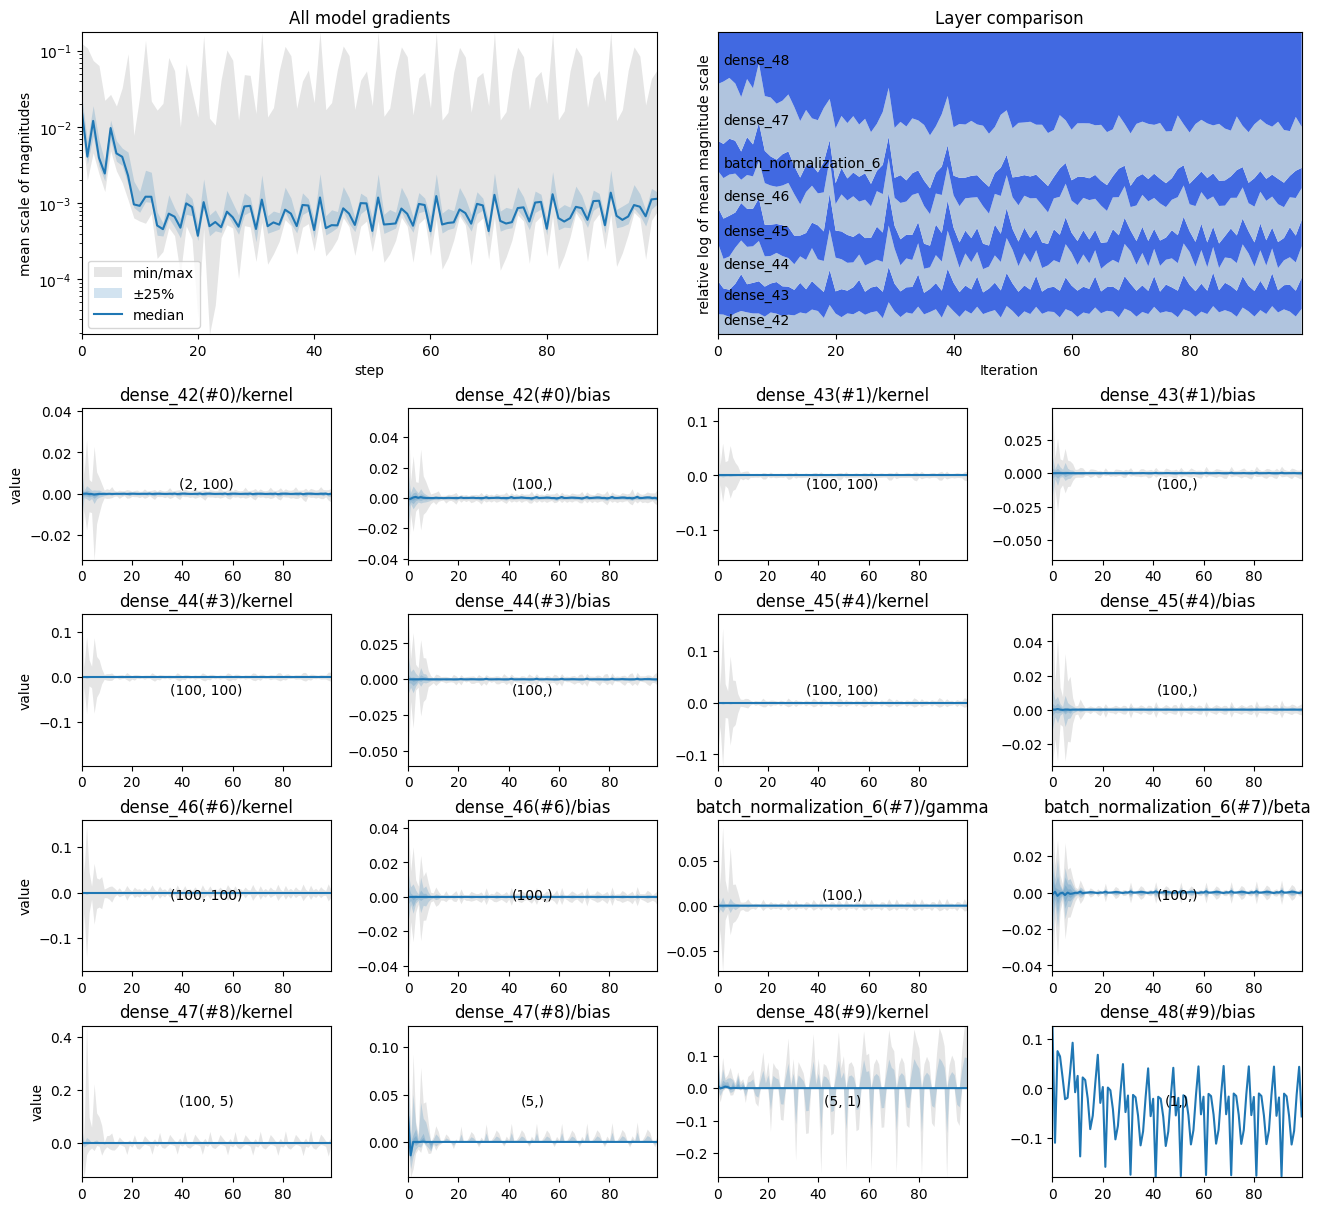

In [45]:
tot.plot_value_history(gradients, magnitudes=False)

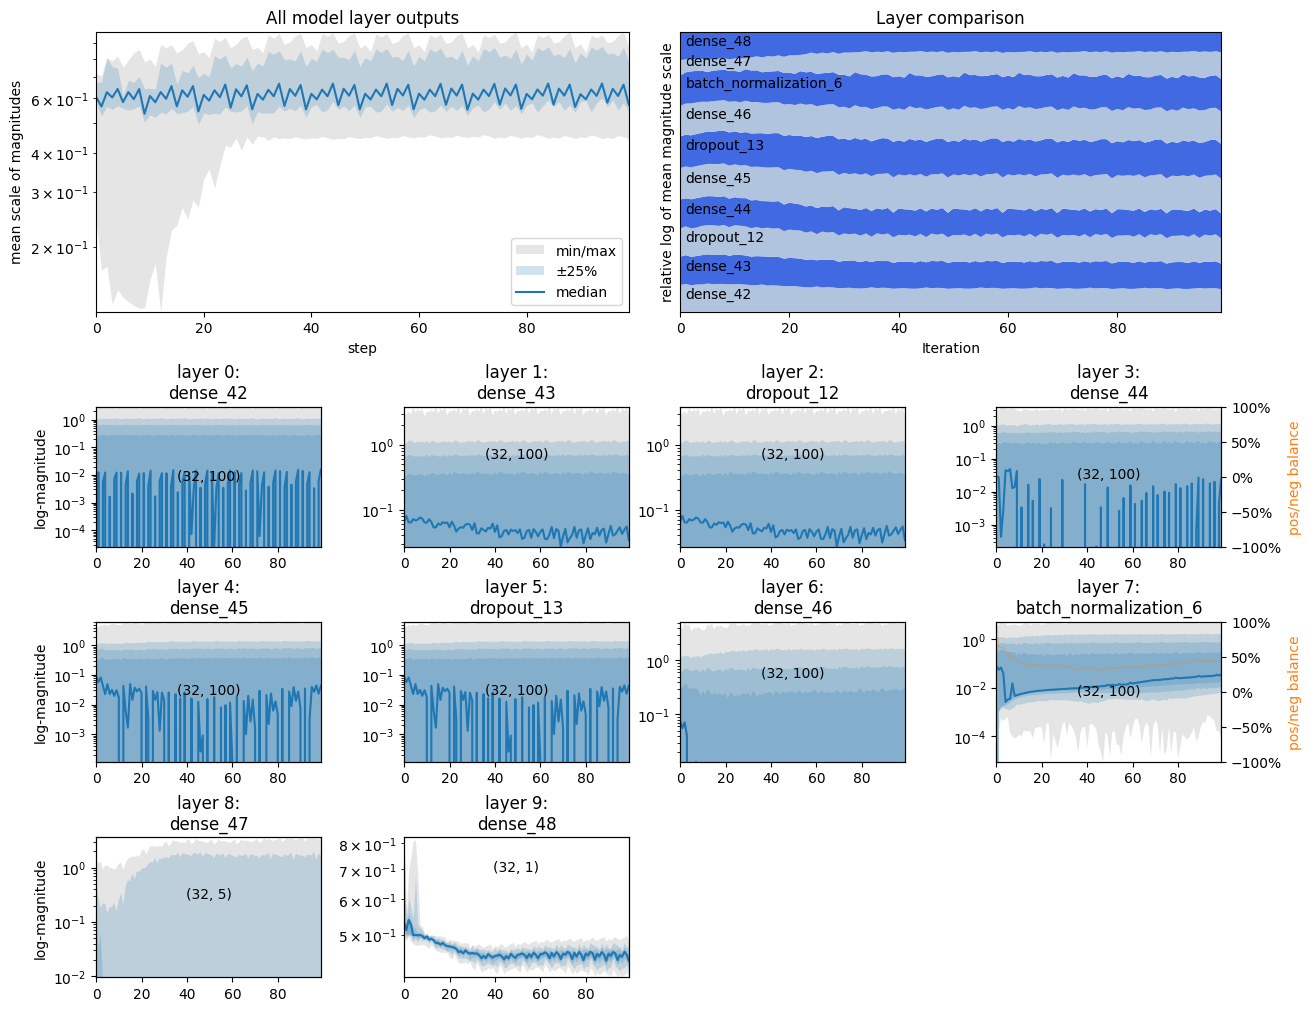

In [36]:
tot.plot_value_history(outputs)

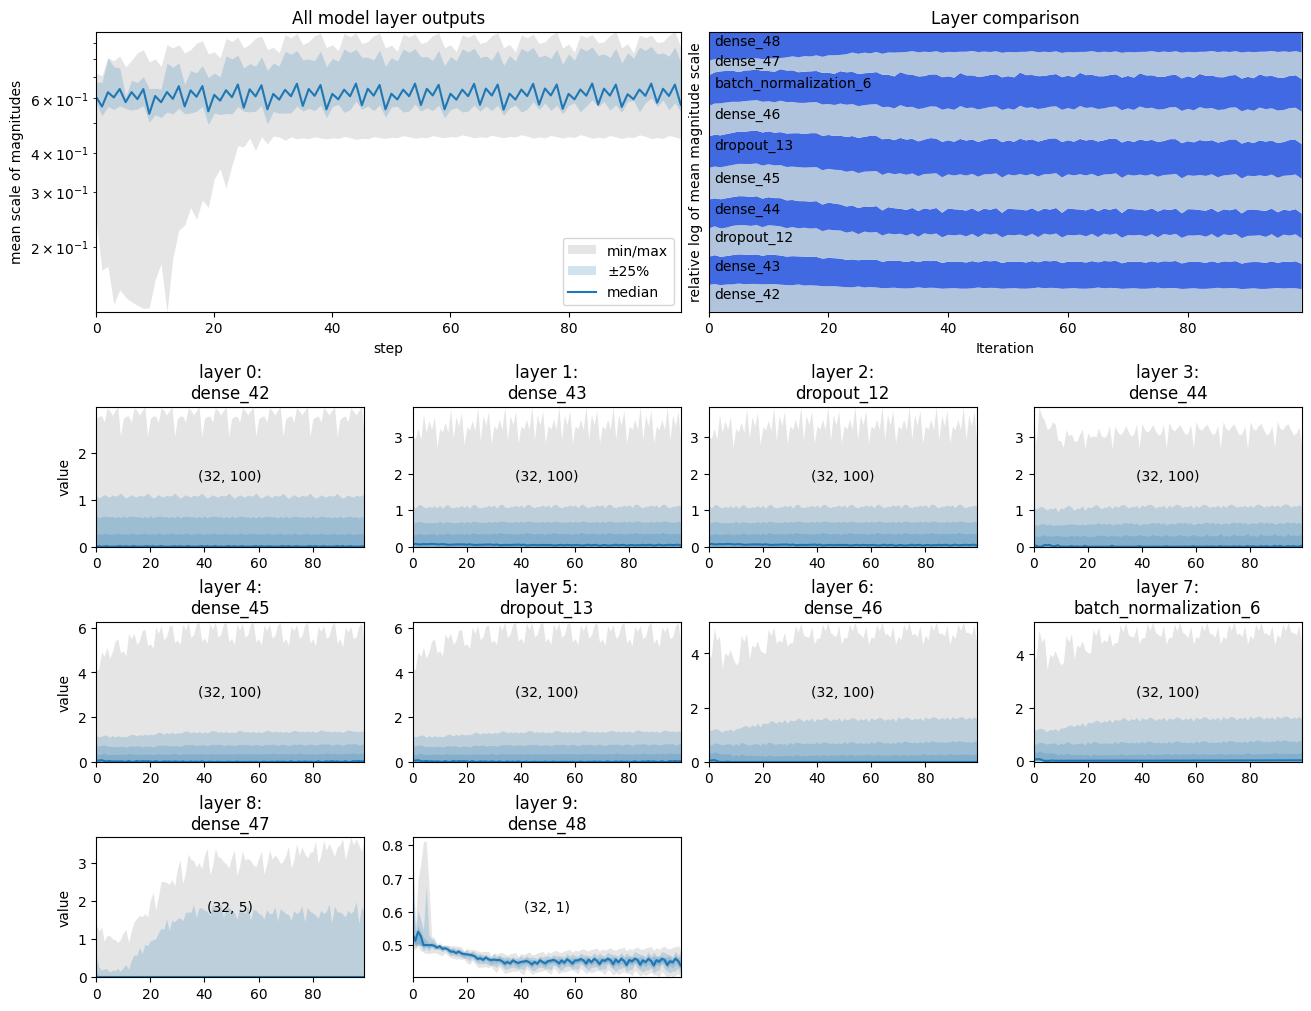

In [46]:
tot.plot_value_history(outputs, magnitudes=False)

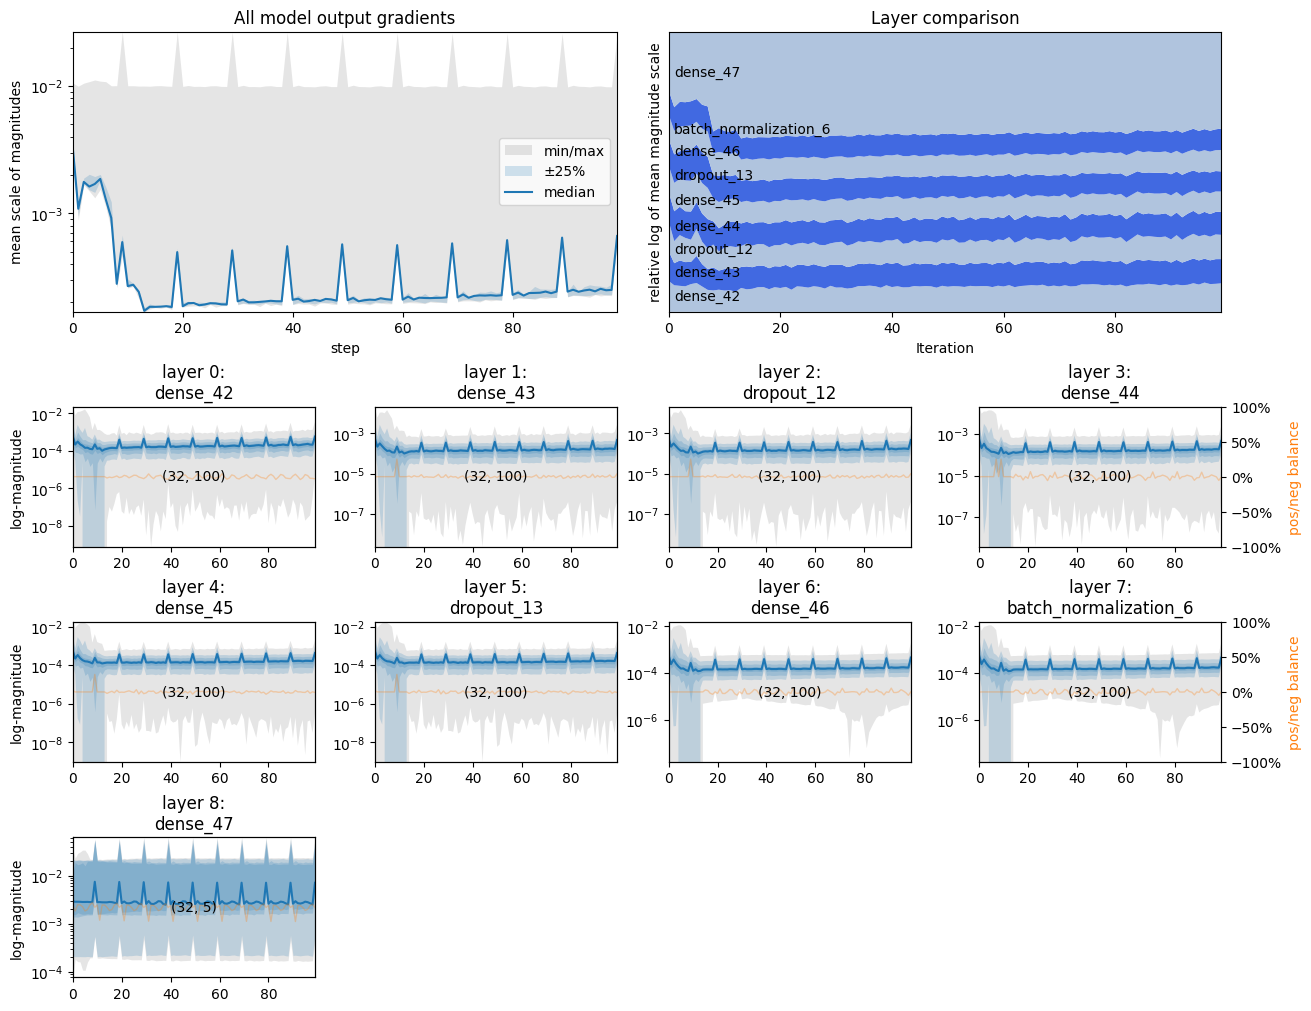

In [38]:
tot.plot_value_history(output_gradients)

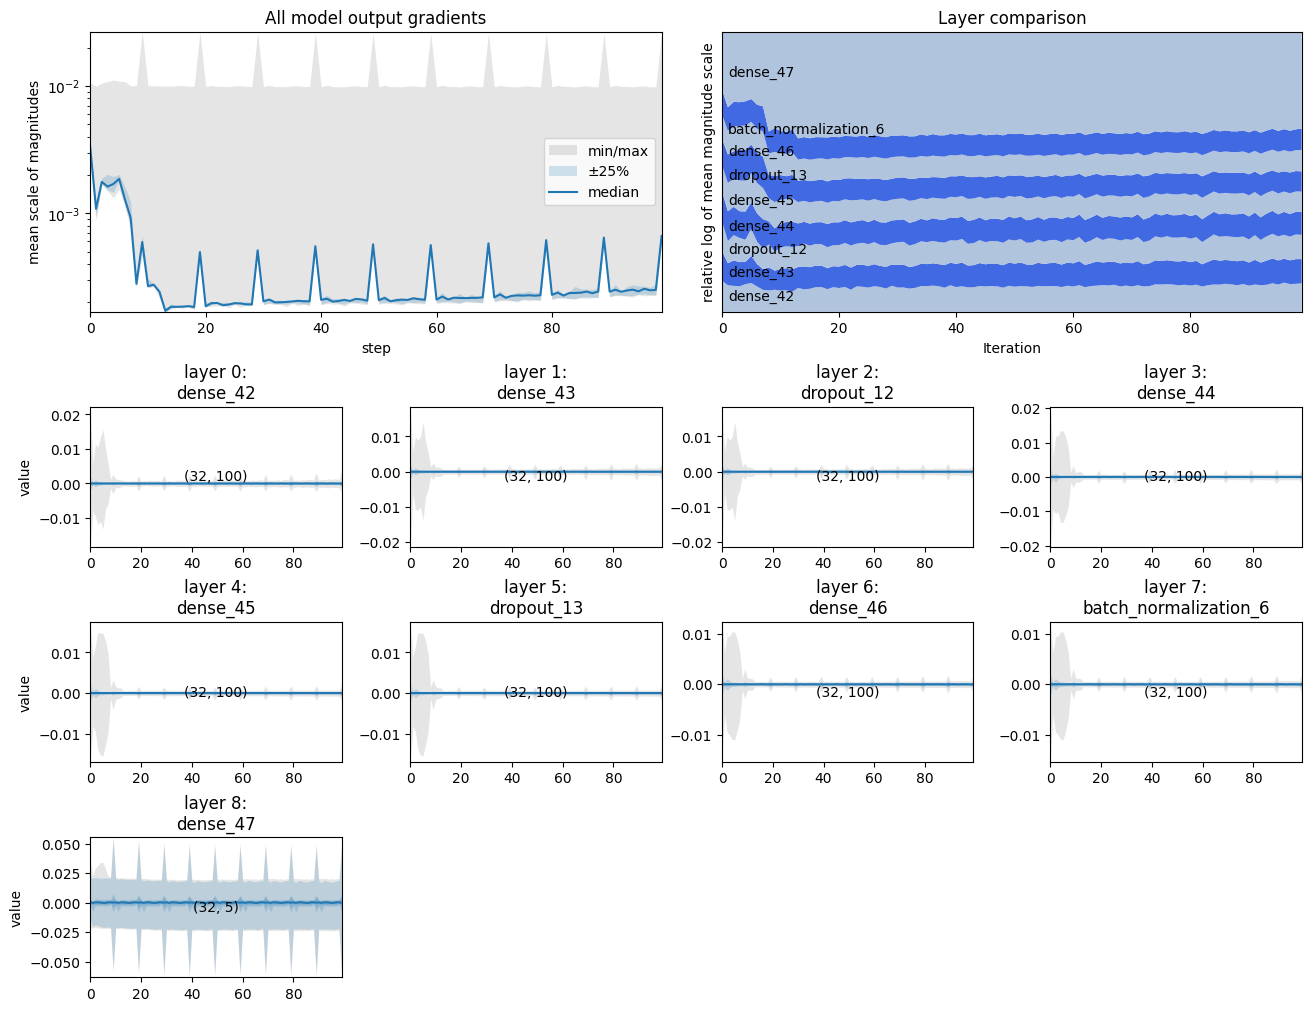

In [47]:
tot.plot_value_history(output_gradients, magnitudes=False)

/content/repo/train_observability_toolkit.py:3061: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


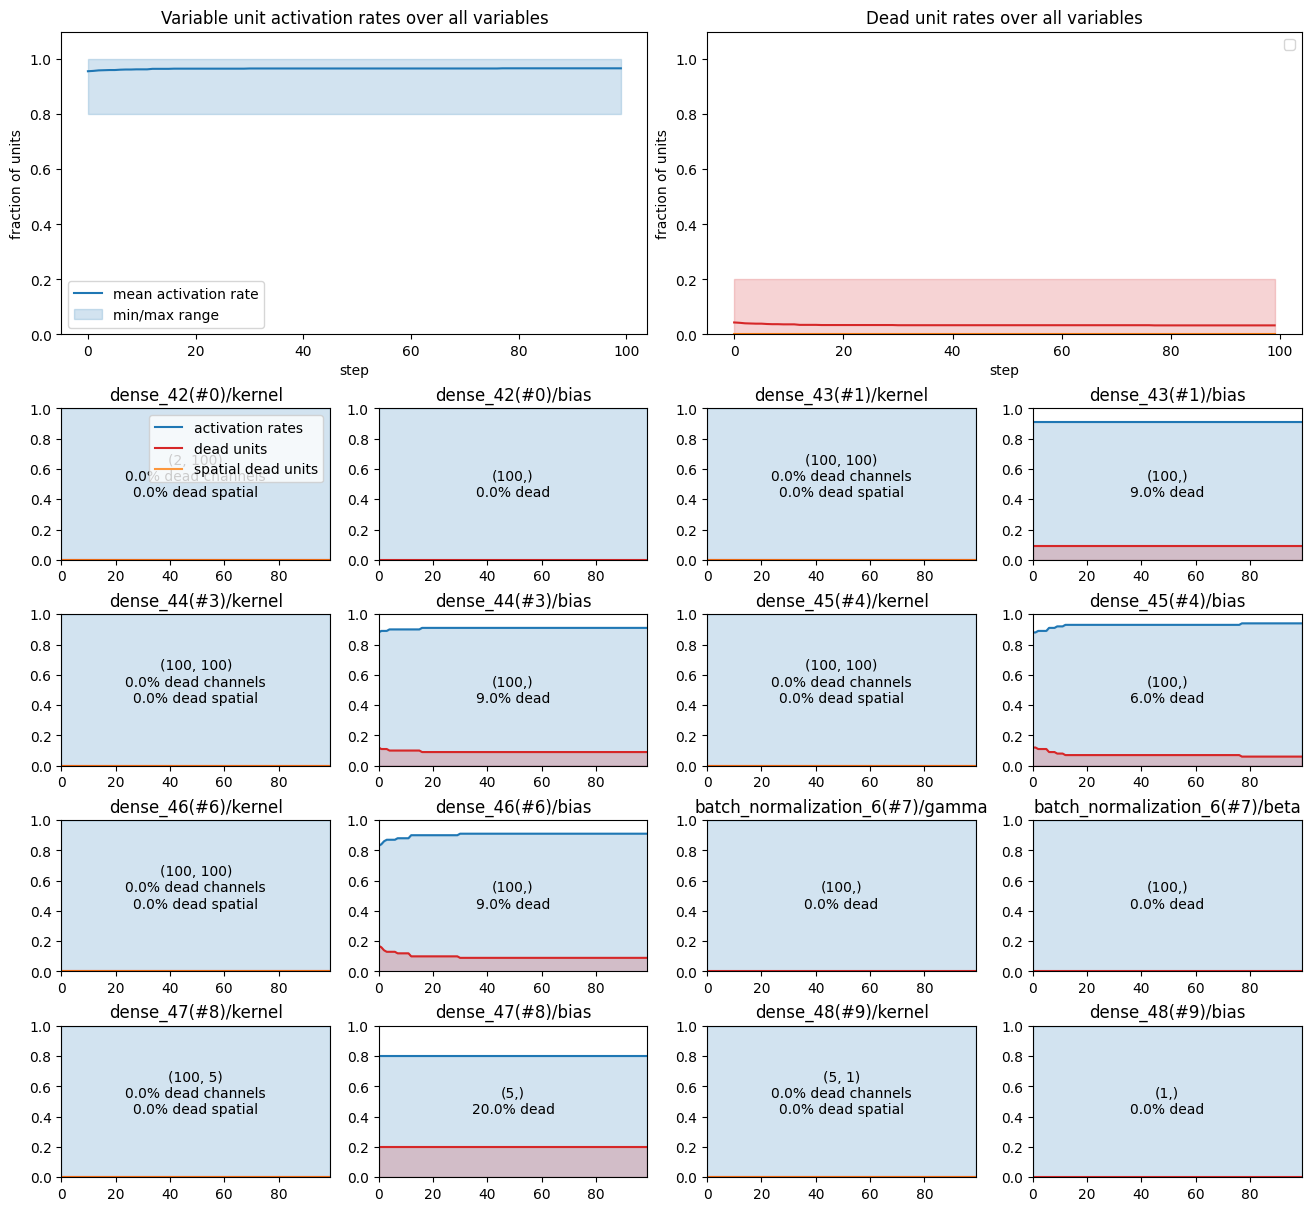

In [40]:
tot.plot_activity_history(variables)

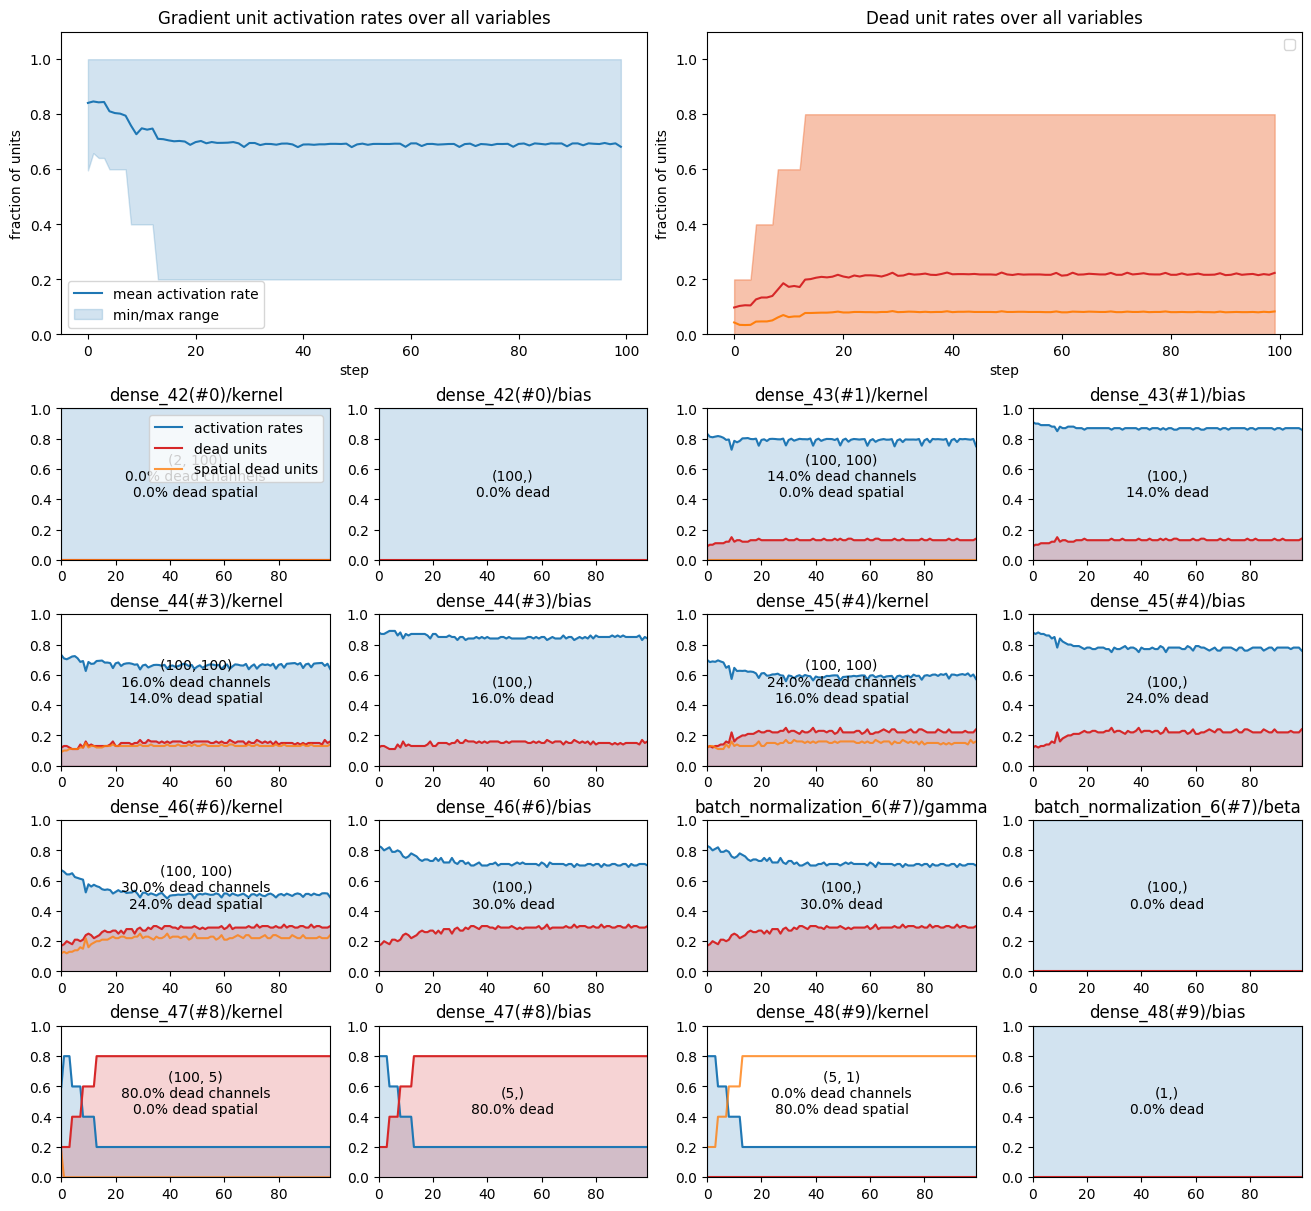

In [41]:
tot.plot_activity_history(gradients)

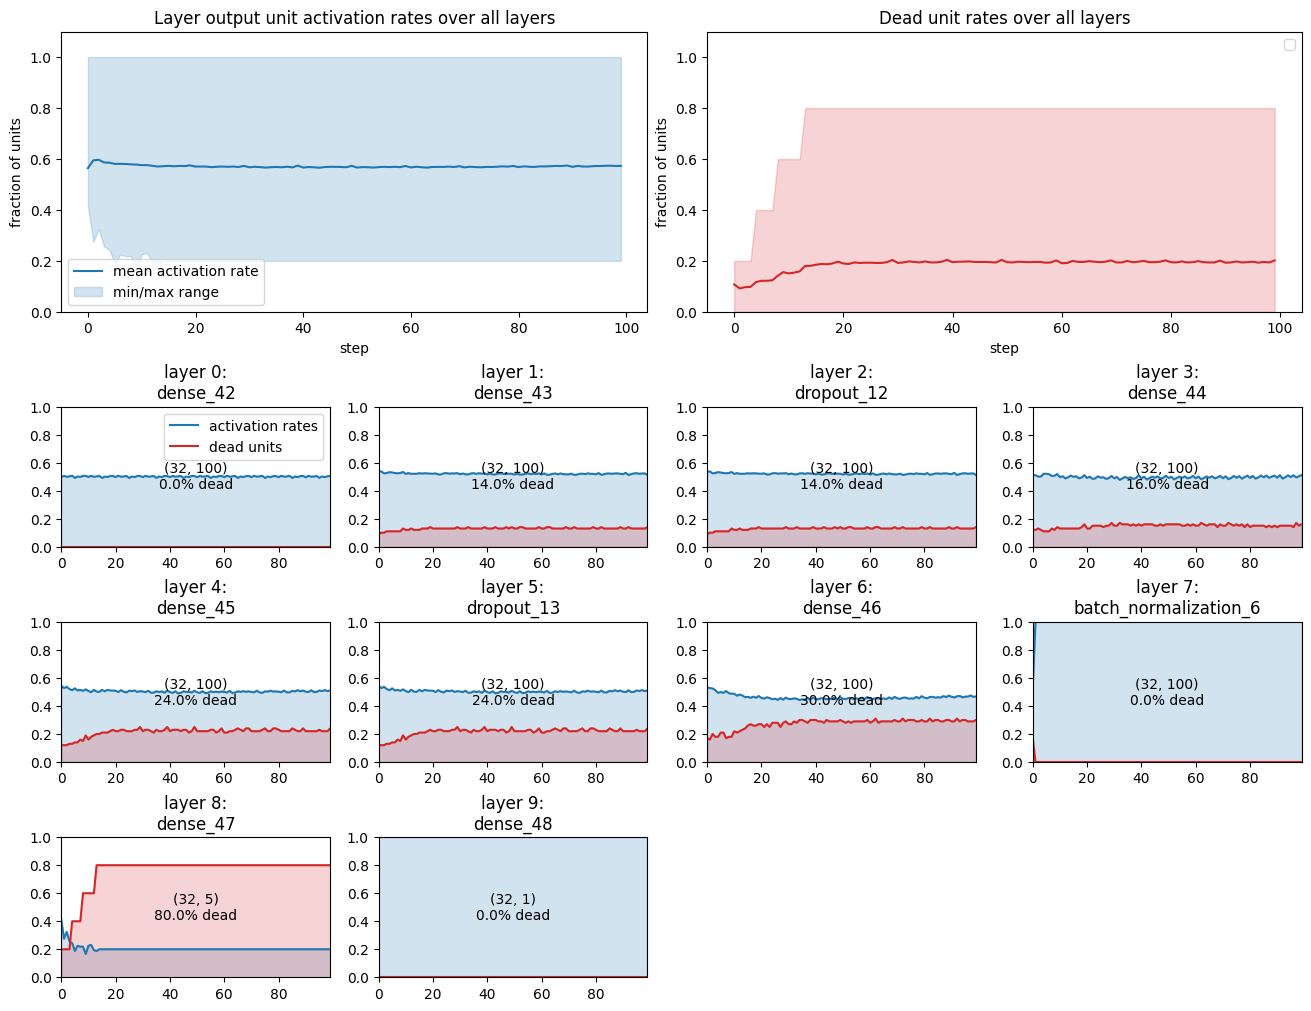

In [42]:
tot.plot_activity_history(outputs)

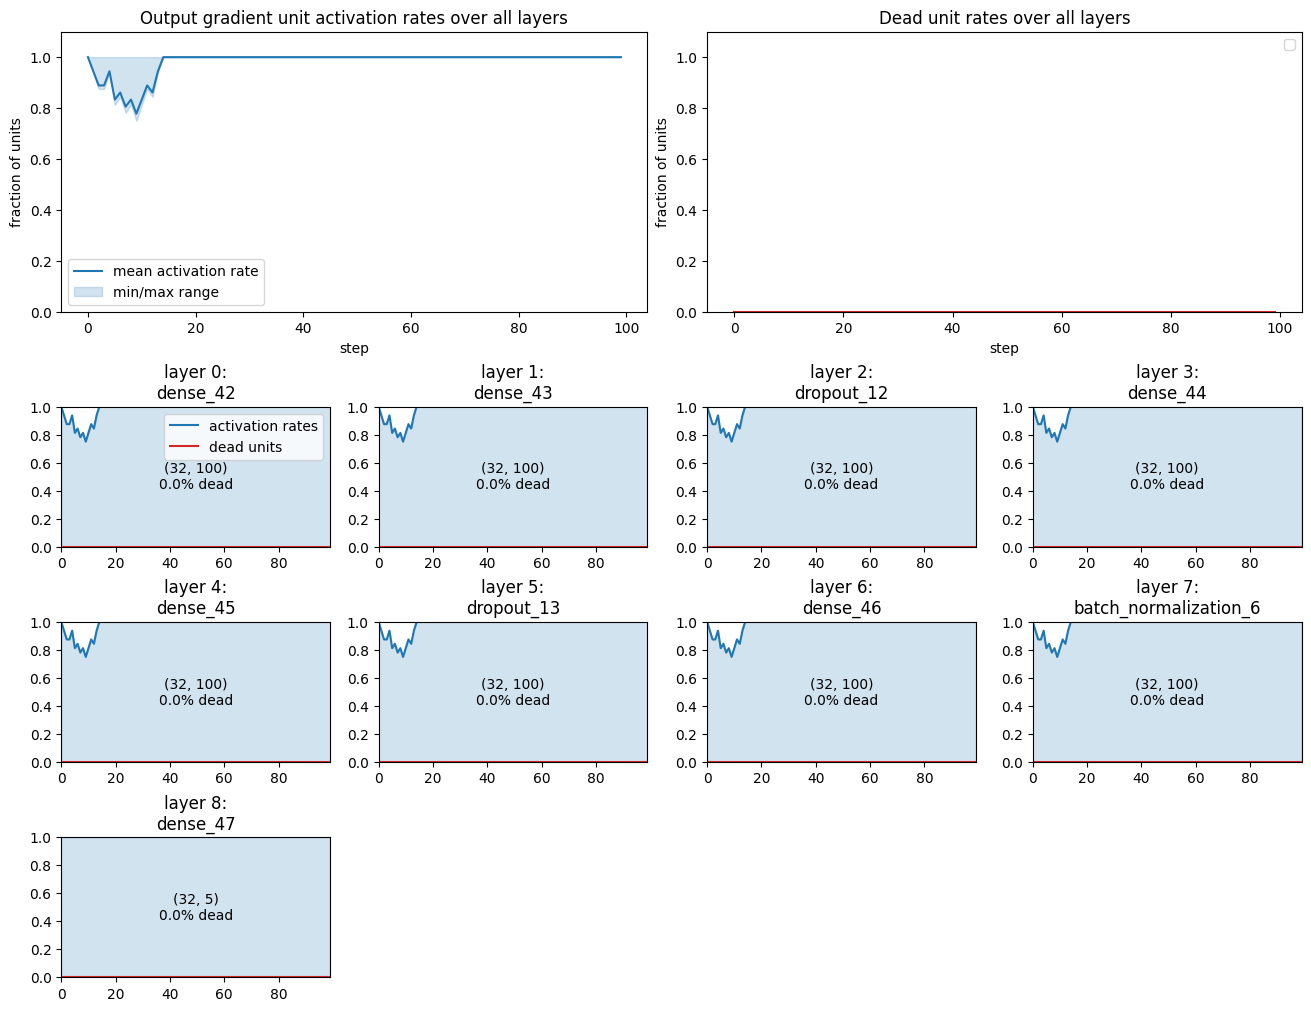

In [43]:
tot.plot_activity_history(output_gradients)

## MNIST CNN

In [ ]:
def mnist_cnn_model():
  model = tf.keras.Sequential([
    layers.Input(shape=(28, 28)),
    layers.Reshape((28, 28, 1)),
    layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='softmax')  # Output layer for 10 classes
  ])
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model

def mnist_dataset():
  np.random.seed(1)
  (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
  # Normalize the data
  x_train = x_train / 255.0
  return x_train, y_train

train_X, train_Y = mnist_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
train_X: (60000, 28, 28), train_Y: (60000,)


Training via custom fit() function. Will produce a few warnings; you can usually ignore these.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_108']
Received: inputs=Tensor(shape=(64, 28, 28))
  warnings.warn(msg)


  1/938 ━━━━━━━━━━━━━━━━━━━━ 26:43 2s/step - accuracy: 0.0938 - loss: 2.3032

931/938 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8475 - loss: 0.2453

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_108']
Received: inputs=Tensor(shape=(32, 28, 28))
  warnings.warn(msg)


938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8482 - loss: 0.2444


Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9750 - loss: 0.0740
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9844 - loss: 0.0501
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9889 - loss: 0.0360
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9912 - loss: 0.0274
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9931 - loss: 0.0214
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9938 - loss: 0.0184
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9948 - loss: 0.0154
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9957 - loss: 0.0119
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9965 - loss: 0.0105
Total training time: 89.60 secs


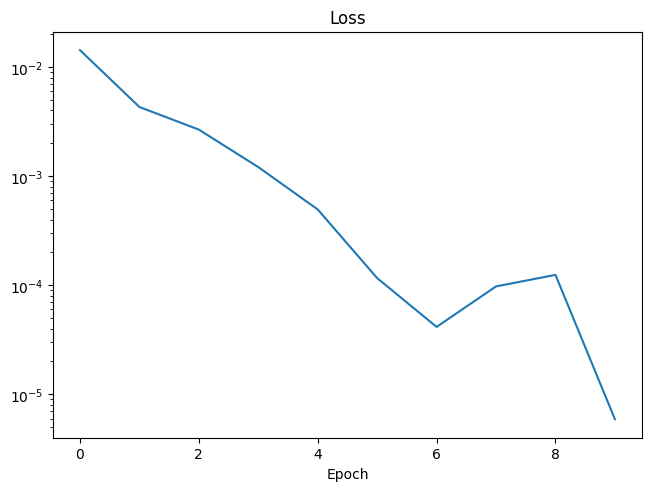

In [ ]:
# Model training
reload(tot)
per_step=False
variables = tot.VariableHistoryCallback(per_step=per_step)
gradients = tot.GradientHistoryCallback(per_step=per_step)
outputs = tot.LayerOutputHistoryCallback(per_step=per_step)
output_gradients = tot.LayerOutputGradientHistoryCallback(per_step=per_step)

start = tf.timestamp()
model = mnist_cnn_model()
train_X, train_Y = mnist_dataset()
if per_step:
  dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).take(1000).batch(64)
  history = tot.fit(model, dataset, epochs=10, callbacks=[variables, gradients, outputs, output_gradients])
else:
  dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(64)
  history = tot.fit(model, dataset, epochs=10, callbacks=[variables, gradients, outputs, output_gradients])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")
plot_fit(history)

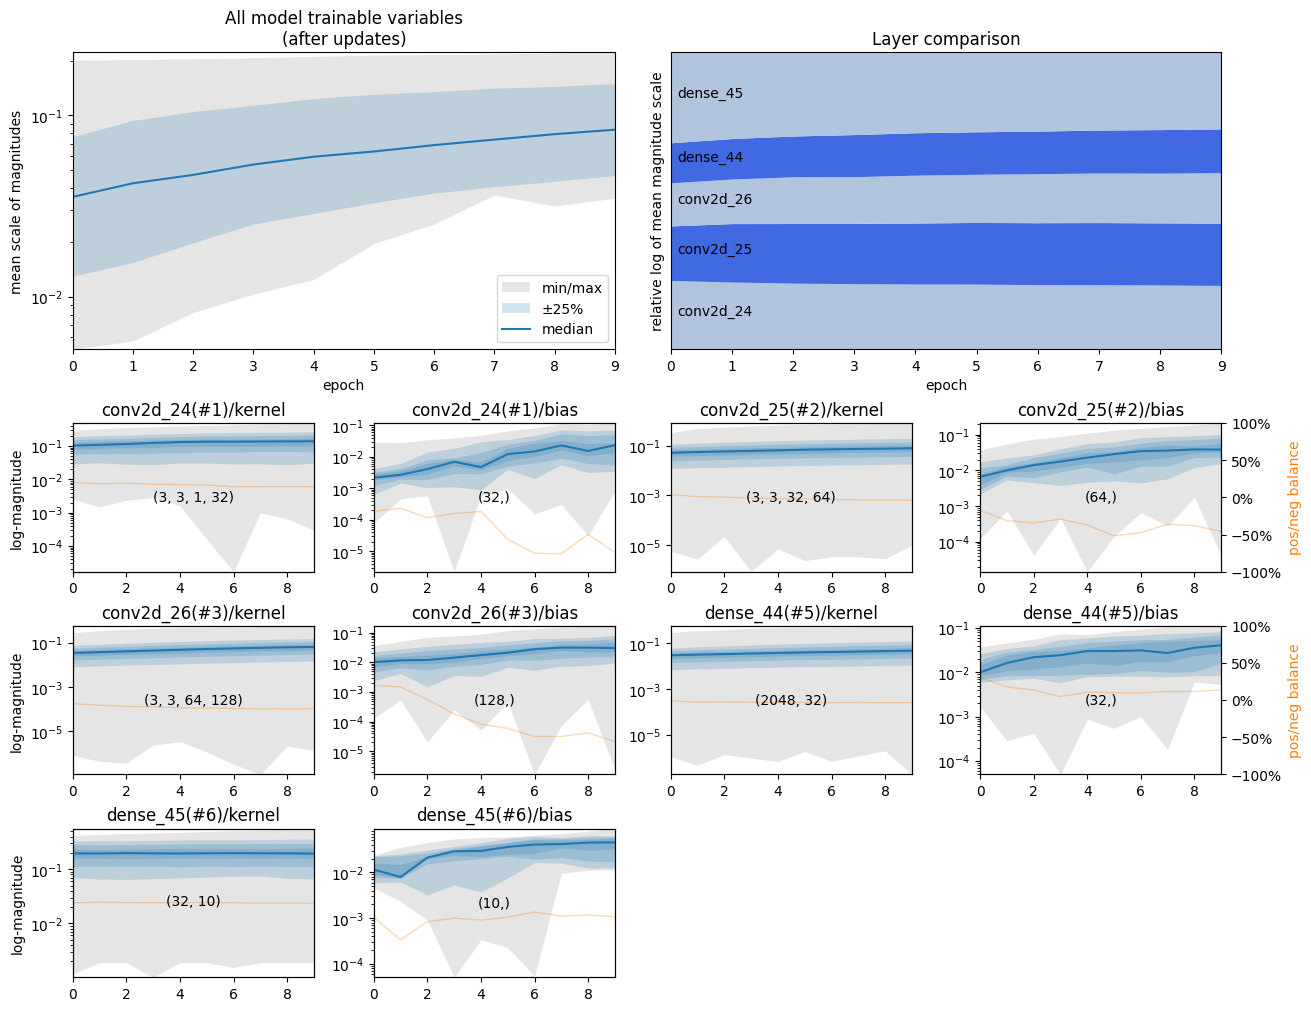

In [ ]:
reload(tot)
tot.plot_value_history(variables)

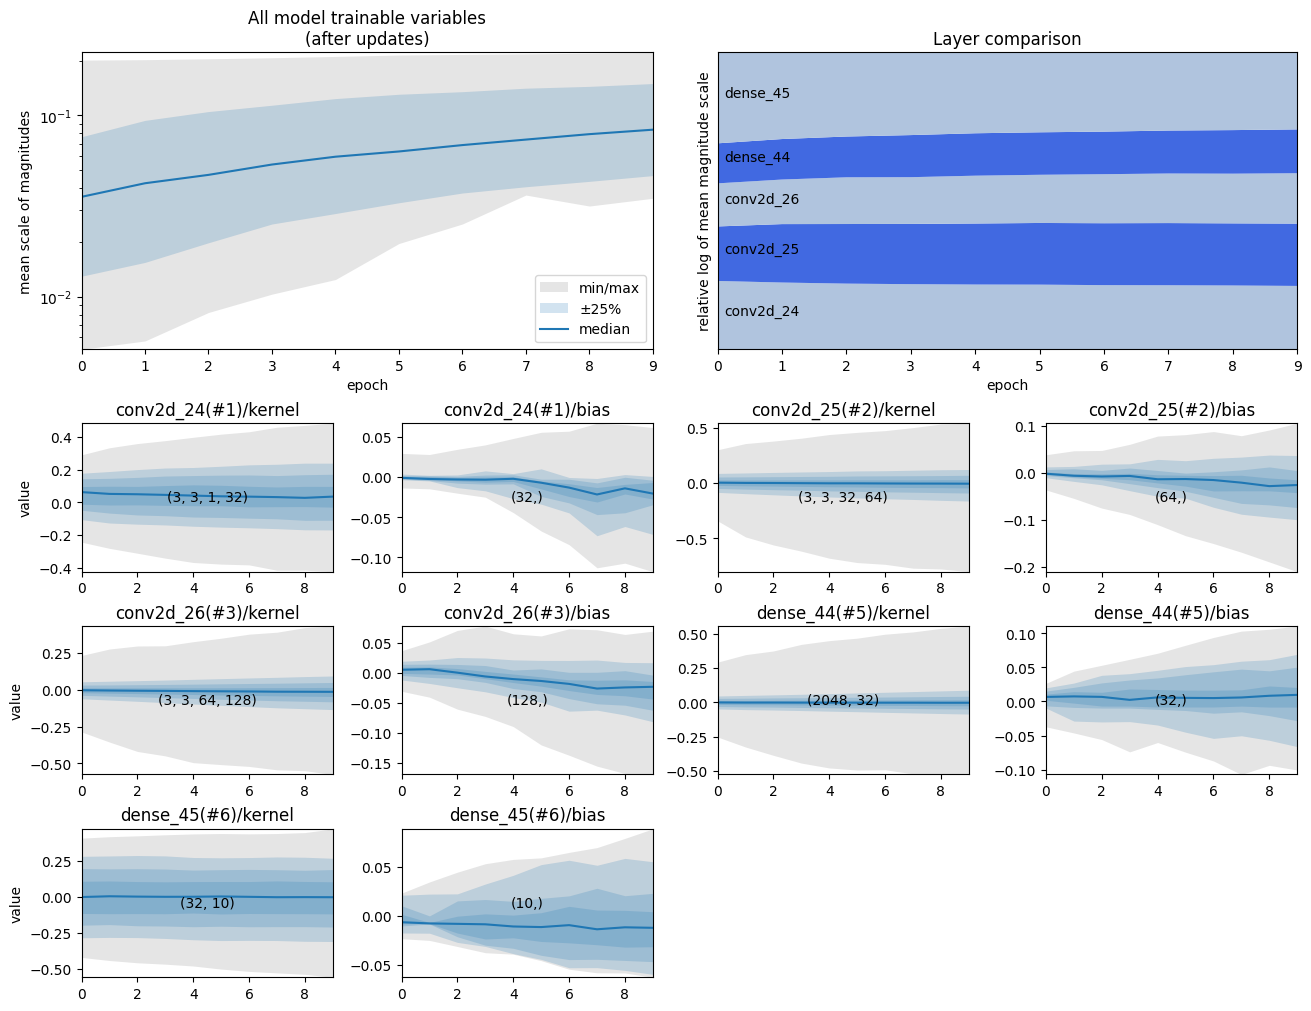

In [ ]:
tot.plot_value_history(variables, magnitudes=False)

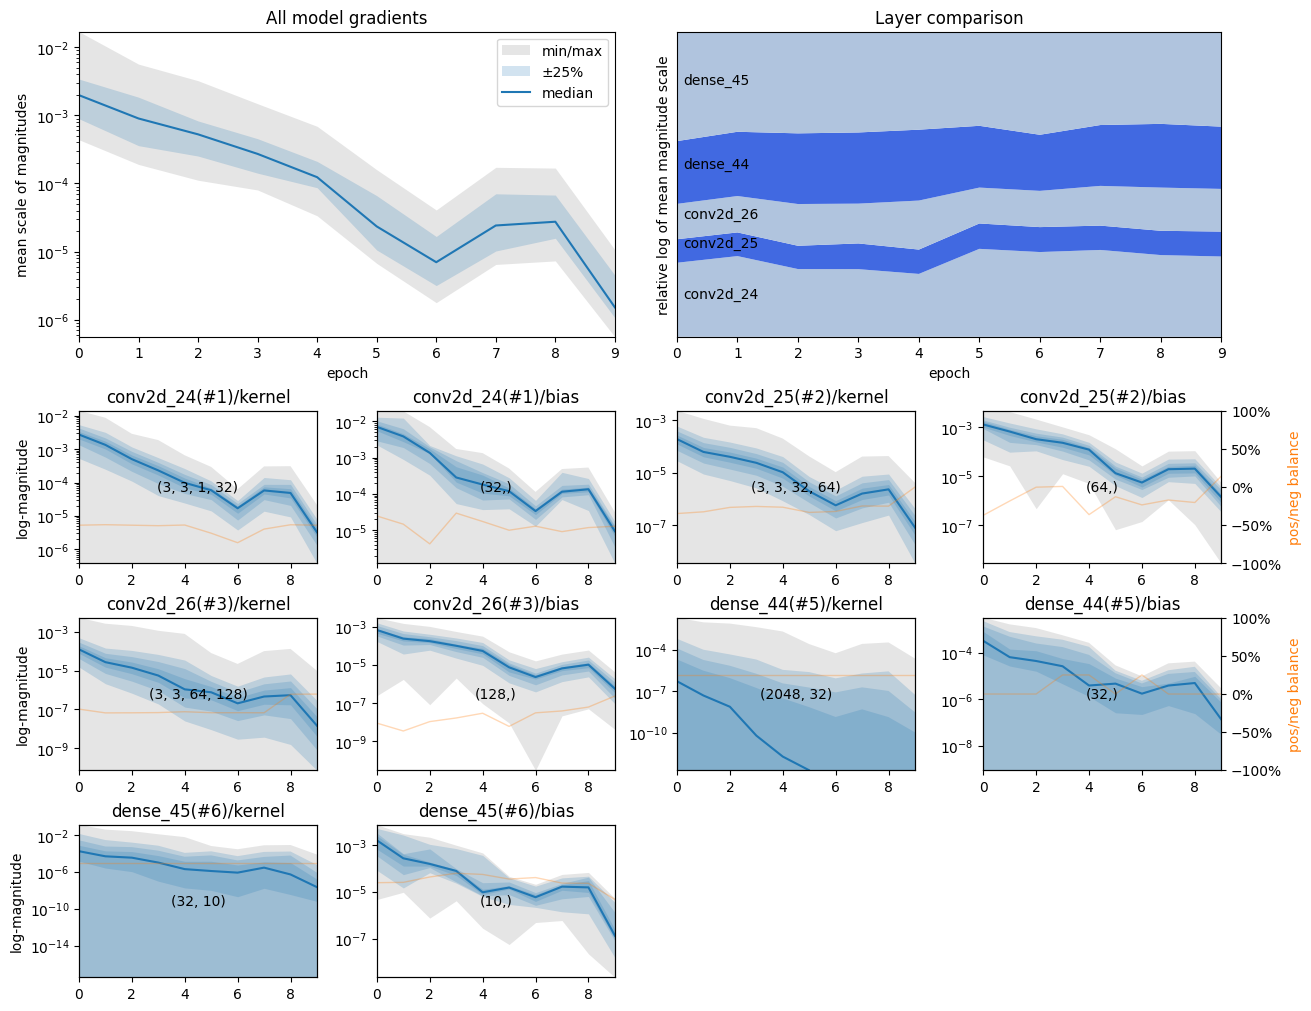

In [ ]:
tot.plot_value_history(gradients)

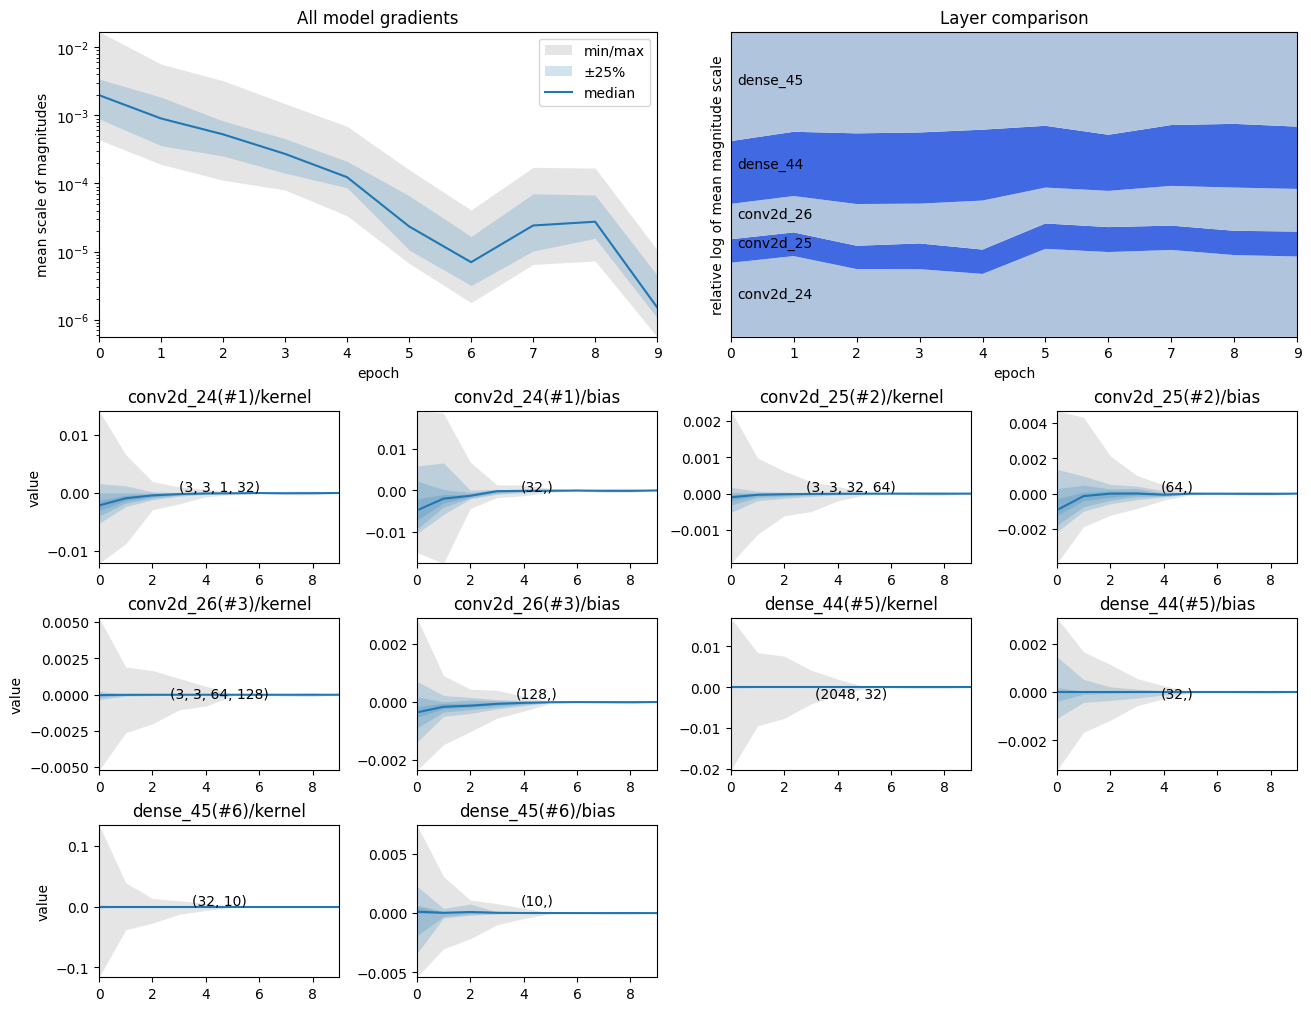

In [ ]:
tot.plot_value_history(gradients, magnitudes=False)

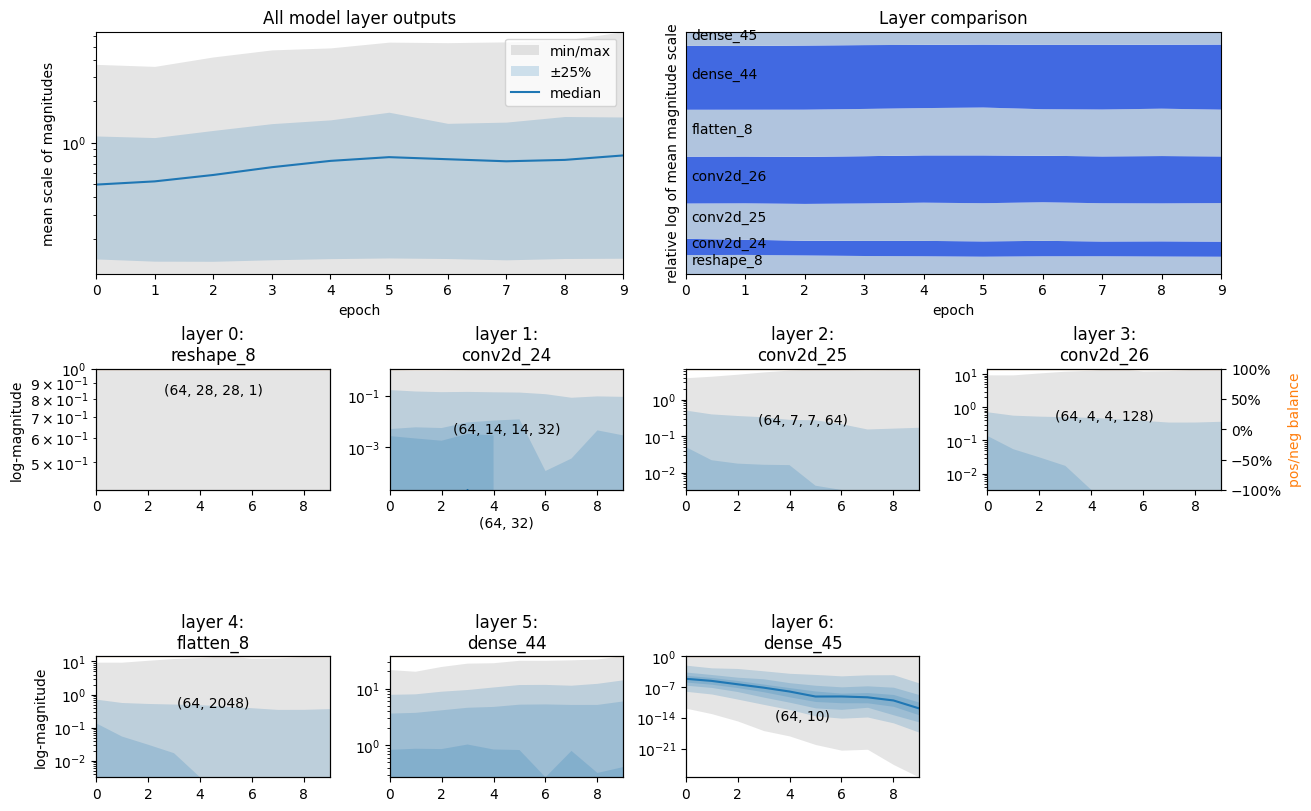

In [ ]:
tot.plot_value_history(outputs)

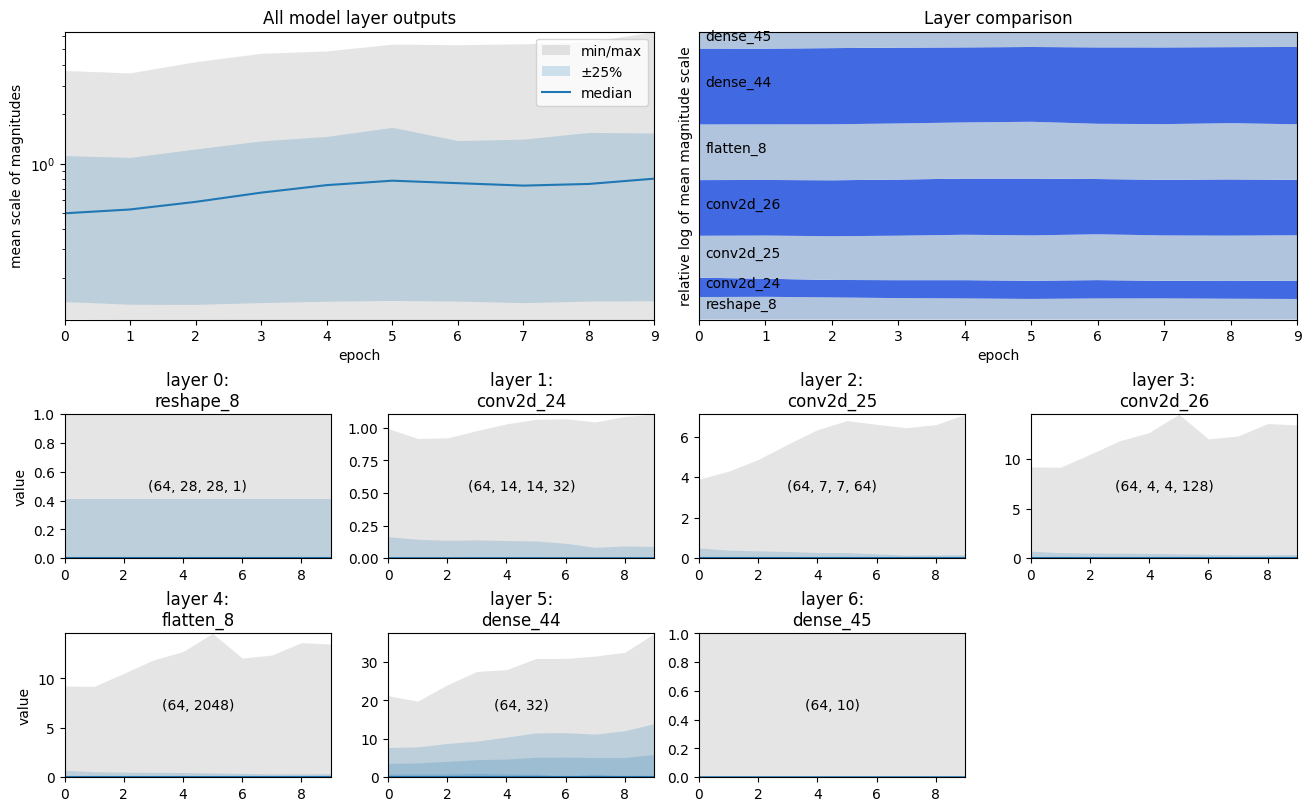

In [ ]:
tot.plot_value_history(outputs, magnitudes=False)

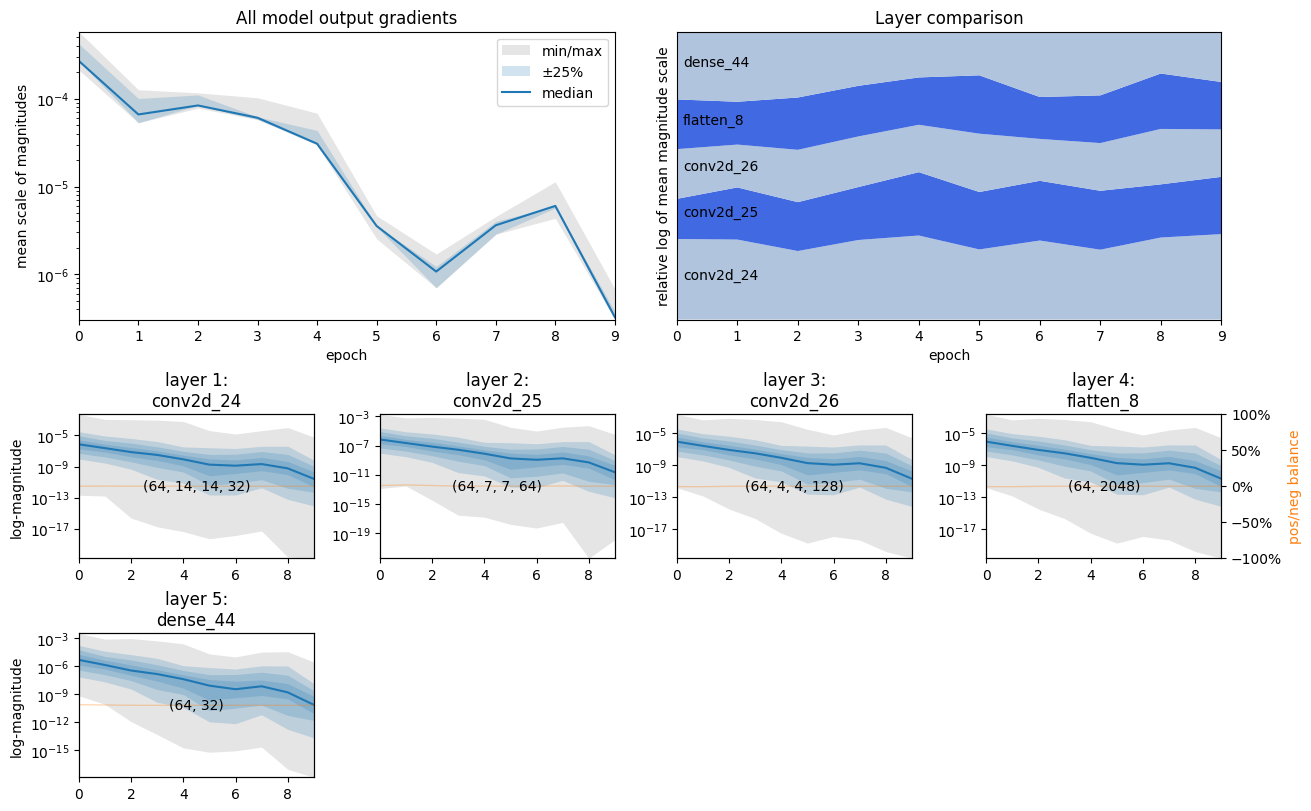

In [ ]:
tot.plot_value_history(output_gradients)

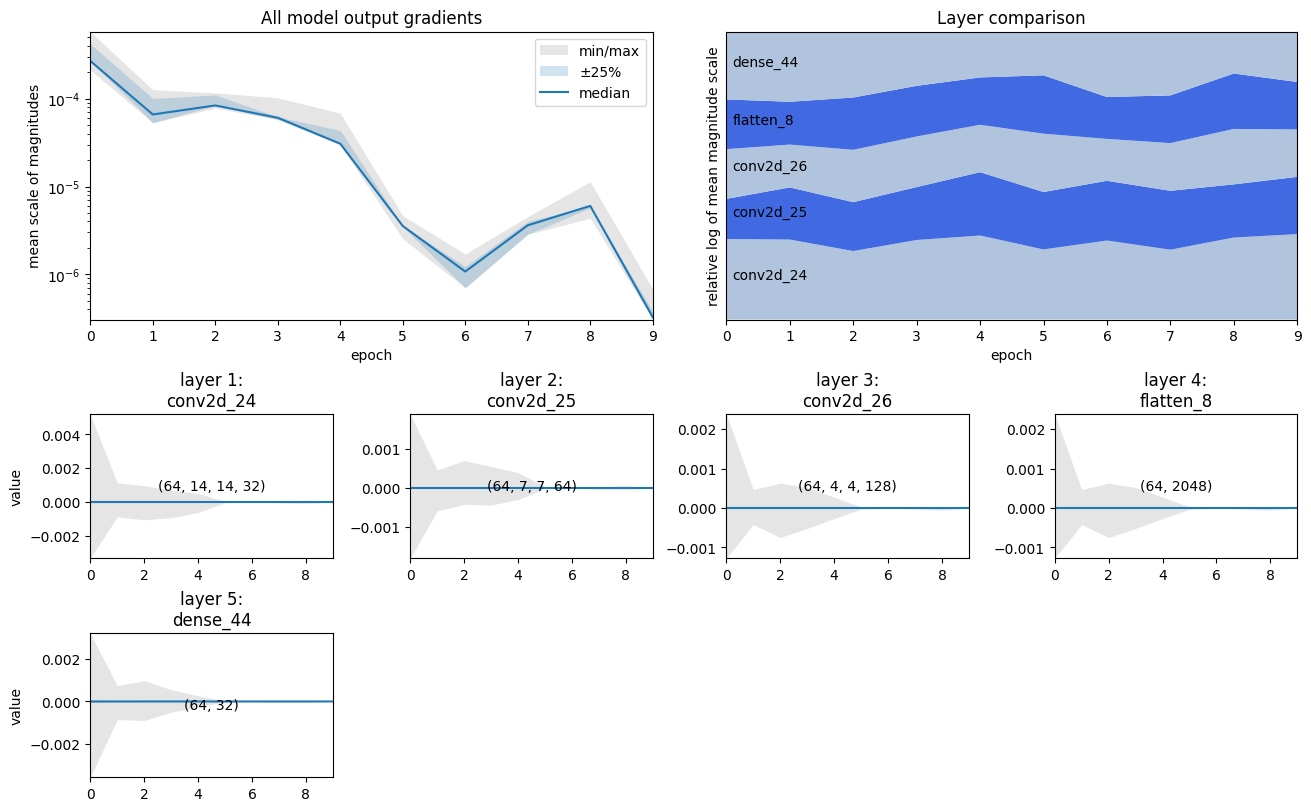

In [ ]:
tot.plot_value_history(output_gradients, magnitudes=False)

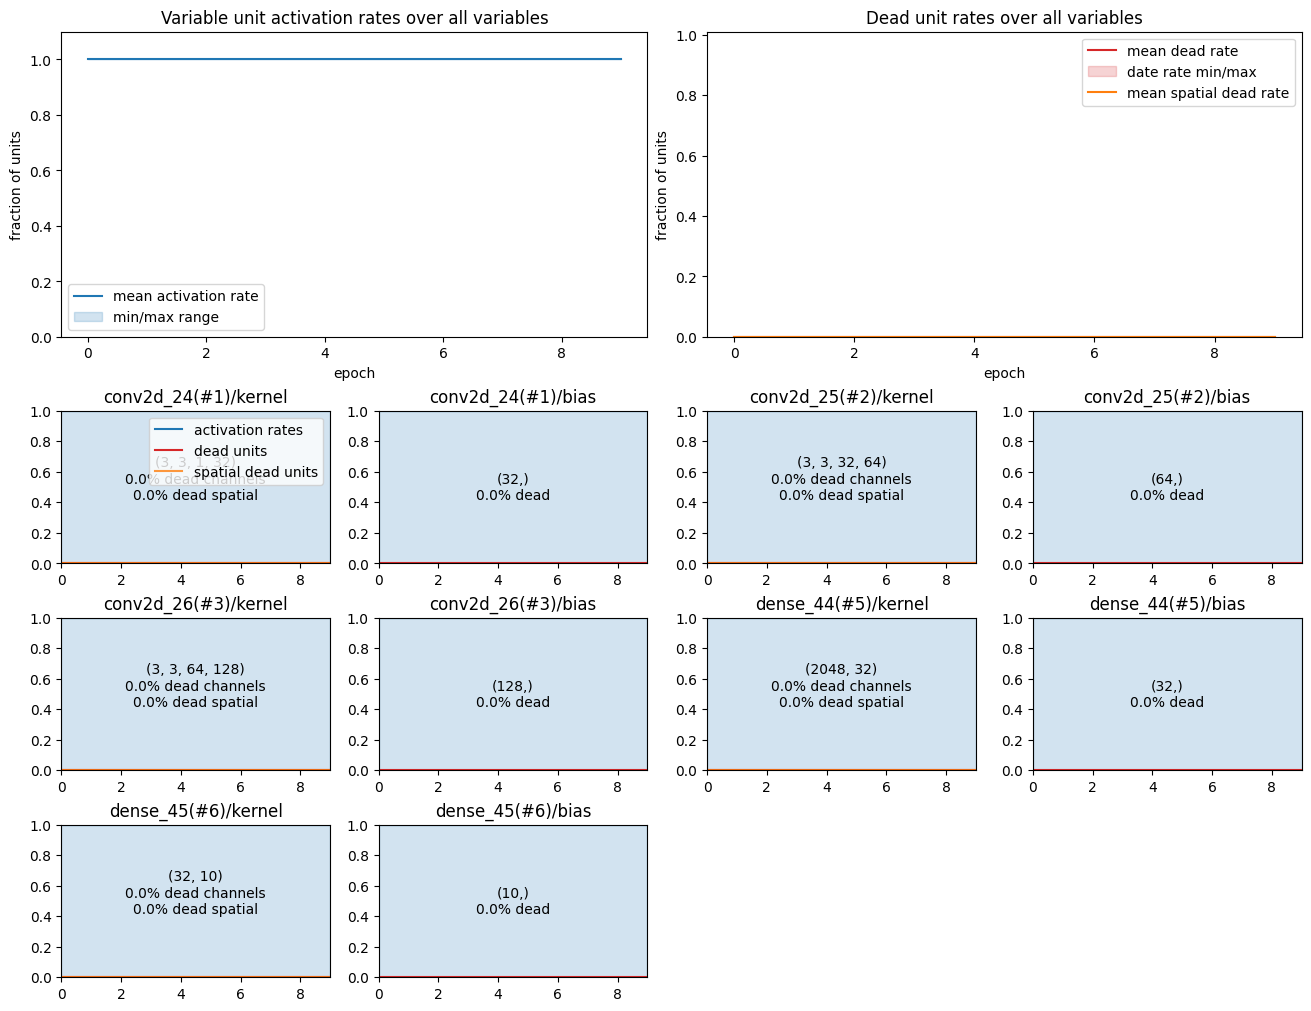

In [ ]:
tot.plot_activity_history(variables)

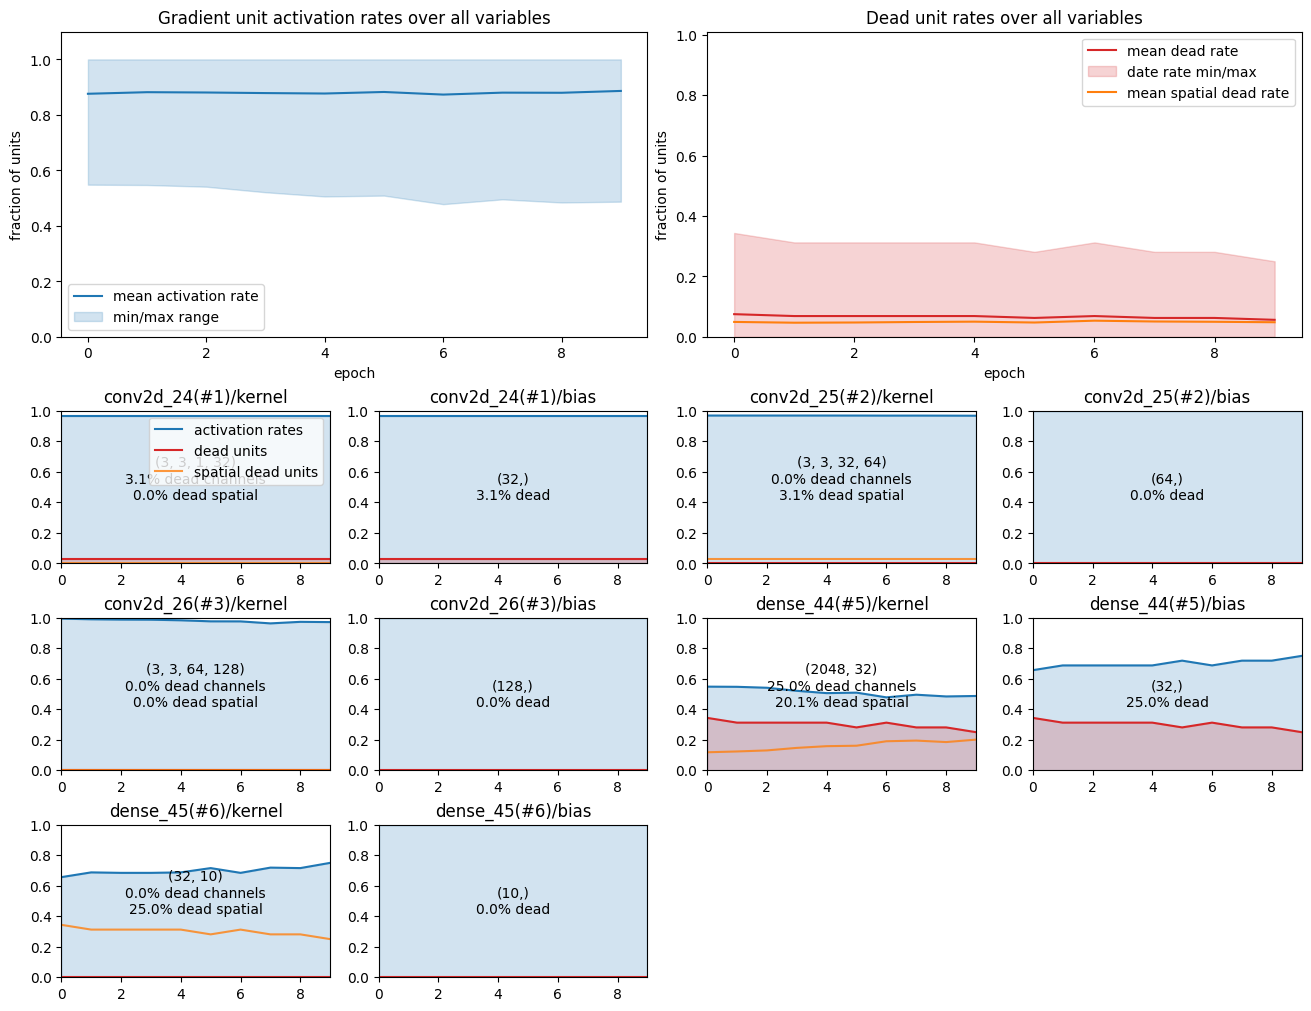

In [ ]:
tot.plot_activity_history(gradients)

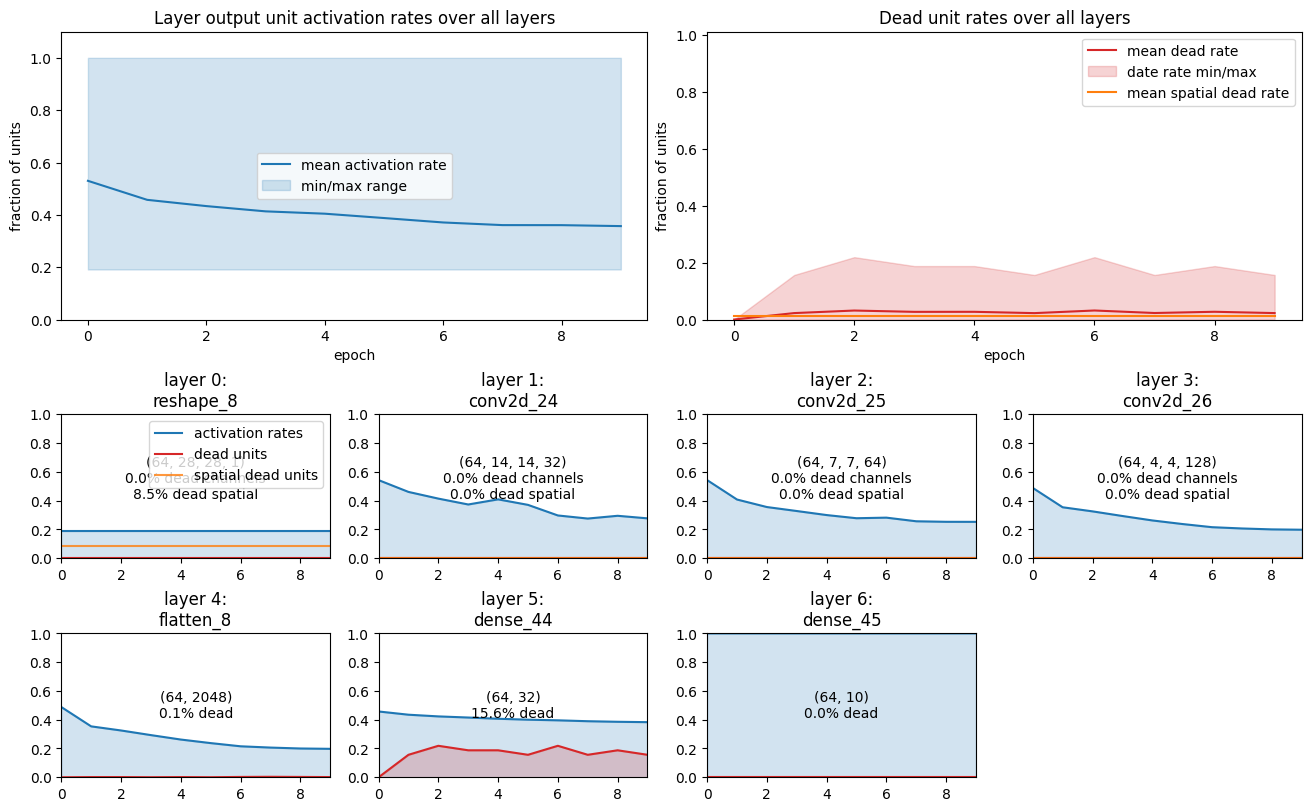

In [ ]:
tot.plot_activity_history(outputs)

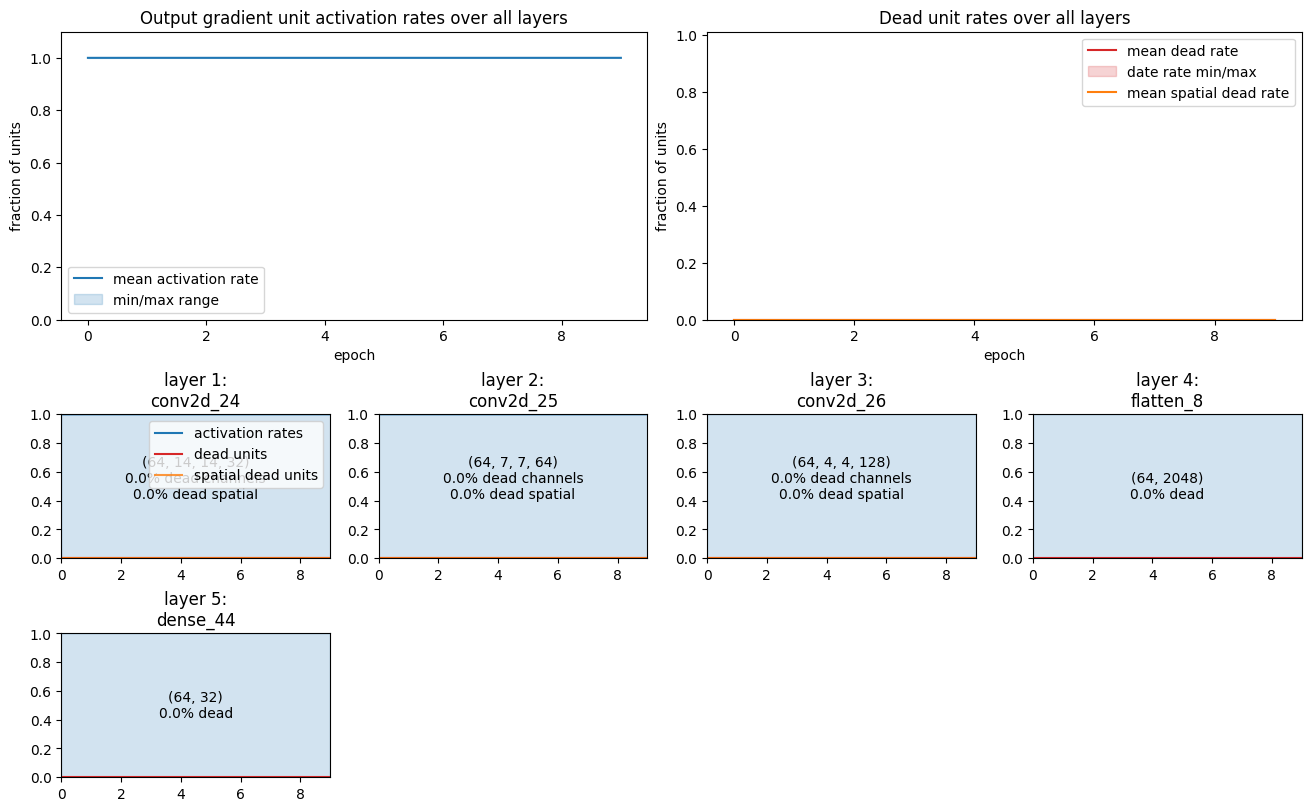

In [ ]:
tot.plot_activity_history(output_gradients)